In [2]:
suppressPackageStartupMessages({
    library(ComplexHeatmap)
    library(logger)
    library(dittoSeq)
    library(scran)
    library(escape)
    library(scater)
})

In [3]:
log_info("Reading SCE object...")
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")
log_info("SCE object done")

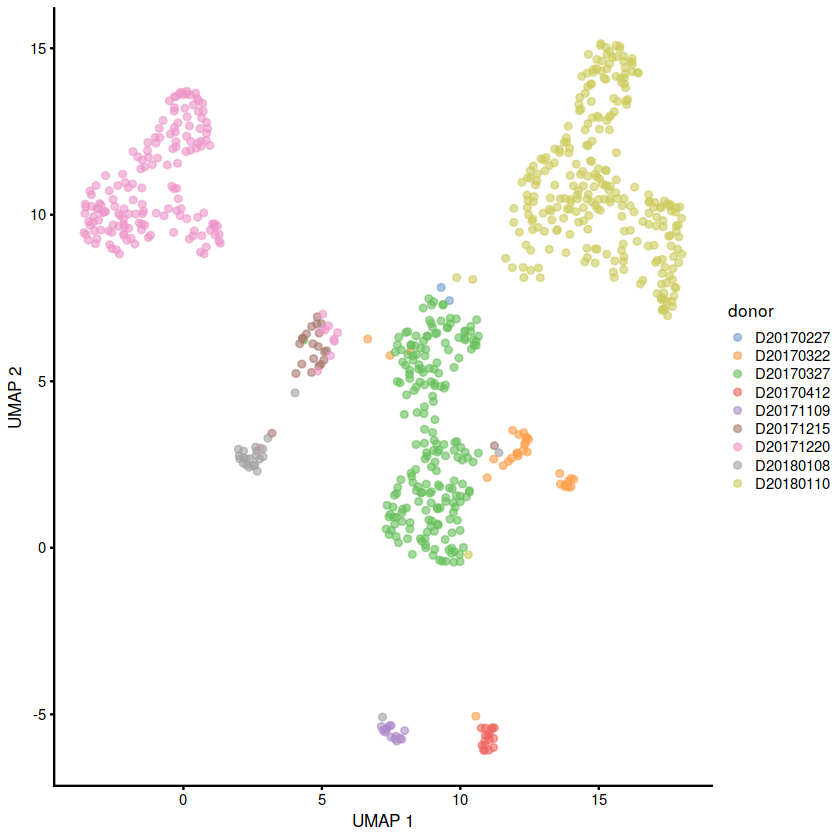

In [3]:
plotUMAP(sce, colour_by = "donor")

# NMF program

In [4]:
# Calculate CPM
cpm(sce) <- calculateCPM(sce)

In [5]:
# Function
suppressPackageStartupMessages(library(NMF))
nmf_programs <- function(cpm, is.log=F, rank, method="snmf/r", seed=1) {
  if(is.log==F) CP100K_log <- log2((cpm/10) + 1) else CP100K_log <- cpm
  CP100K_log <- CP100K_log[apply(CP100K_log, 1, function(x) length(which(x > 3.5)) > ncol(CP100K_log)*0.02),]
  CP100K_log <- CP100K_log - rowMeans(CP100K_log)
  CP100K_log[CP100K_log < 0] <- 0
  nmf_programs <- nmf(CP100K_log, rank=rank, method=method, seed=seed)
  nmf_programs_scores <- list(w_basis=basis(nmf_programs), h_coef=t(coef(nmf_programs)))                                 
  return(nmf_programs_scores)
}

In [8]:
table(sce$donor)


D20170227 D20170322 D20170327 D20170412 D20171109 D20171220 D20180108 D20180110 
        2        31       203        17        14       159        22       267 

In [9]:
sce <- sce[, grep("^HCC", sce$celltype)]

In [14]:
donor <- c("D20170322", "D20170327", "D20171220", "D20180110")

## Keep genes

In [10]:
avg <- calculateAverage(sce, assay.type = 'logcounts') 
#avg <- calculateAverage(sce) 

keep <- (rowData(sce)$Biotype == 'protein_coding') & (avg > 1)


In [11]:
table(keep)

keep
FALSE  TRUE 
50921  9761 

## Perform NMF with ranks ranging from 3 to 9       

In [12]:
w_basis_tumor <- list() # nmf gene scores
h_coef_tumor <- list() # nmf cell scores

In [15]:
for(i in donor) {
    log_info("NMF for {i}")
    w <- NULL
    h <- NULL
    mt_for_nmf <- as.matrix(cpm(sce[keep, sce$donor == i]))
   
    for (j in 3:9) {
        log_info("Rank {j}")
        n <- nmf_programs(mt_for_nmf, rank=j)
        colnames(n$w_basis) <- paste0(i, "_", j, ".", 1:j)
        colnames(n$h_coef) <- paste0(i, "_", j, ".", 1:j)
        w <- cbind(w, n$w_basis)
        h <- cbind(h, n$h_coef)
    }
    
    w_basis_tumor[[i]] <- w
    h_coef_tumor[[i]] <- h
}

## Writing out

In [12]:
saveRDS(w_basis_tumor, file = "./output/NMF/w_basis_tumor.rds")
saveRDS(h_coef_tumor, file = "./output/NMF/h_coef_tumor.rds")

# Identify Recurrent Program

In [3]:
w_basis_tumor <- readRDS("./output/NMF/w_basis_tumor.rds")
h_coef_tumor <- readRDS("./output/NMF/h_coef_tumor.rds")

In [16]:
# - nmf_programs = a list; each element contains a matrix with NMF programs (top 50 genes) generated for a specific cell line using different NMF factorization ranks. 
# - intra_min = minimum overlap with a program from the same cell line (for selecting robust programs)
# - intra_max = maximum overlap with a program from the same cell line (for removing redundant programs)
# - inter_filter = logical; indicates whether programs should be filtered based on their similarity to programs of other cell lines
# - inter_min = minimum overlap with a program from another cell line 

# Returns a character vector with the NMF programs selected

robust_nmf_programs <- function(nmf_programs, intra_min = 35, intra_max = 10, inter_filter=T, inter_min = 10) {
    
    # Select NMF programs based on the minimum overlap with other NMF programs from the same cell line
    intra_intersect <- lapply(nmf_programs, function(z) apply(z, 2, function(x) apply(z, 2, function(y) length(intersect(x,y))))) 
    intra_intersect_max <- lapply(intra_intersect, function(x) apply(x, 2, function(y) sort(y, decreasing = T)[2]))             
    nmf_sel <- lapply(names(nmf_programs), function(x) nmf_programs[[x]][,intra_intersect_max[[x]]>=intra_min]) 
    names(nmf_sel) <- names(nmf_programs)
                            
    # Select NMF programs based on i) the maximum overlap with other NMF programs from the same cell line and
    # ii) the minimum overlap with programs from another cell line
    nmf_sel_unlist <- do.call(cbind, nmf_sel)
    inter_intersect <- apply(nmf_sel_unlist , 2, function(x) apply(nmf_sel_unlist , 2, function(y) length(intersect(x,y)))) ## calculating intersection between all programs
                                                                   
    final_filter <- NULL 
    for(i in names(nmf_sel)) {
        a <- inter_intersect[grep(i, colnames(inter_intersect), invert = T),grep(i, colnames(inter_intersect))]
        b <- sort(apply(a, 2, max), decreasing = T) # for each cell line, ranks programs based on their maximum overlap with programs of other cell lines
        if(inter_filter==T) b <- b[b>=inter_min] # selects programs with a maximum intersection of at least 10
        if(length(b) > 1) {
            c <- names(b[1]) 
            for(y in 2:length(b)) {
                if(max(inter_intersect[c,names(b[y])]) <= intra_max) c <- c(c,names(b[y])) # selects programs iteratively from top-down. Only selects programs that have a intersection smaller than 10 with a previously selected programs
                }
            final_filter <- c(final_filter, c)
        } else {
            final_filter <- c(final_filter, names(b))
        }
    }
    return(final_filter)                                                      
}
    

In [17]:
nmf_programs_genes_tumor <- w_basis_tumor
nmf_programs_sig_tumor <- lapply(nmf_programs_genes_tumor, function(x) apply(x, 2, function(y) names(sort(y, decreasing = T))[1:50]))

for each cell line, select robust NMF programs (i.e. obseved using different ranks in the same cell line), remove redundancy due to multiple ranks, and apply a filter based on the similarity to programs from other cell lines. 

In [18]:

nmf_filter_tumor <- robust_nmf_programs(nmf_programs_sig_tumor, intra_min = 35, intra_max = 10, inter_filter=T, inter_min = 10)
nmf_programs_sig_tumor <- lapply(nmf_programs_sig_tumor, function(x) x[, is.element(colnames(x), nmf_filter_tumor),drop=F])
nmf_programs_sig_tumor <- do.call(cbind, nmf_programs_sig_tumor)

## Calculate similarity between programs


In [19]:
nmf_intersect_tumor <- apply(nmf_programs_sig_tumor , 2, function(x) apply(nmf_programs_sig_tumor , 2, function(y) length(intersect(x,y)))) 

## Hierarchical clustering of the similarity matrix 


In [20]:
nmf_intersect_hc_tumor <- hclust(as.dist(50-nmf_intersect_tumor), method="ward.D2") 
nmf_intersect_hc_tumor <- reorder(as.dendrogram(nmf_intersect_hc_tumor), colMeans(nmf_intersect_tumor))
nmf_intersect_tumor <- nmf_intersect_tumor[order.dendrogram(nmf_intersect_hc_tumor), order.dendrogram(nmf_intersect_hc_tumor)]

## Plot similarity matrix heatmap     


Loading required package: viridisLite



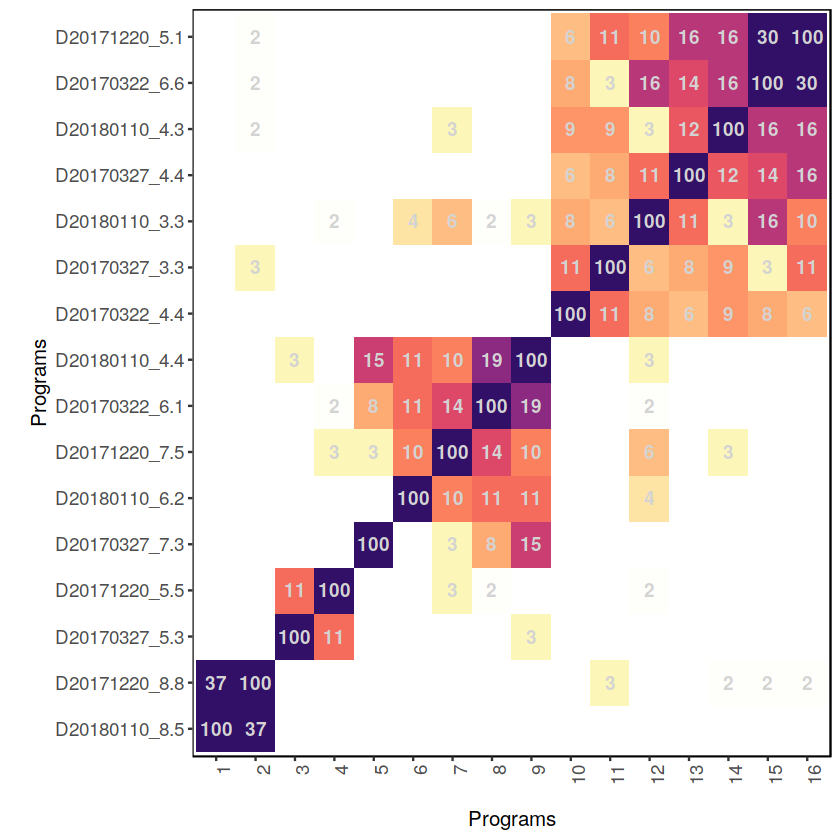

In [21]:
nmf_intersect_melt_tumor <- reshape2::melt(nmf_intersect_tumor) 
# Custom color palette
library(RColorBrewer)
library(viridis)
custom_magma <- c(colorRampPalette(c("white", rev(magma(323, begin = 0.15))[1]))(10), rev(magma(323, begin = 0.18)))
p5.1 <- ggplot(data = nmf_intersect_melt_tumor, aes(x=Var1, y=Var2, fill=100*value/(100-value))) + 
  geom_tile() + 
  geom_text(data = nmf_intersect_melt_tumor[nmf_intersect_melt_tumor$value >= 2,], aes(label = round(100*value/(100-value))), color = 'lightgrey', fontface = 'bold') +
  scale_color_gradient2(limits=c(2,25), low=custom_magma[1:111],  mid =custom_magma[112:222], high = custom_magma[223:333], midpoint = 13.5, 
                        oob=scales::squish, name="Similarity\n(Jaccard index)") +                                
  scale_fill_gradient2( limits=c(2,25), low=custom_magma[1:111],  mid =custom_magma[112:222], high = custom_magma[223:333], midpoint = 13.5, 
                       oob=scales::squish, name="Similarity\n(Jaccard index)")  +
  
  scale_x_discrete(name="\nPrograms", label = c(1:17)) + 
  scale_y_discrete(name="\nPrograms")  +
  geom_vline(xintercept=c(424,504), linetype="longdash", size=0.6)+
  guides(fill = guide_colourbar(barheight = 4, barwidth = 1)) +
  theme(#plot.background = element_rect(fill = 'lightgrey'), axis.ticks = element_blank(), 
        panel.border = element_rect(fill=F), 
        panel.background = element_blank(),  
        axis.line = element_blank(), 
        axis.text = element_text(size = 11), 
        axis.title = element_text(size = 12), 
        axis.text.x = element_text(angle = 90, hjust = 1 ,vjust = 1),
        legend.position = 'top',
        legend.title = element_text(size=11), 
        legend.text = element_text(size = 10), legend.text.align = 0.5, legend.justification = "bottom") 
p5.1


# Define metaprograms 
Genes observed in at least 25% of programs composing the respective metacluster) 

In [23]:
sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[1:2]])/length(1:2), decreasing=T)


        ANP32E          AURKA          CASC5          CCNB1         CDC25B 
           1.0            1.0            1.0            1.0            1.0 
         CDKN3          CENPA          CENPF          CKAP2          CKS1B 
           1.0            1.0            1.0            1.0            1.0 
          CKS2          DTYMK         FAM83D          H2AFZ          HMGB2 
           1.0            1.0            1.0            1.0            1.0 
         HMGB3          KIF22         KNSTRN          KPNA2         NUSAP1 
           1.0            1.0            1.0            1.0            1.0 
          PRC1          RHNO1          SPAG5          STMN1         TUBA1B 
           1.0            1.0            1.0            1.0            1.0 
        TUBB4B          UBE2T            AFP          APOA2        ARL6IP1 
           1.0            1.0            0.5            0.5            0.5 
          BRD8           BUB3       C19orf48          CENPL          CEP70 
           

In [22]:
nmf_meta1_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[1:2]])/length(1:2), decreasing=T)
nmf_meta1_tumor_programs <- colnames(nmf_intersect_tumor)[1:2] 

nmf_meta2_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[3:4]])/length(3:4), decreasing=T)
nmf_meta2_tumor_programs <- colnames(nmf_intersect_tumor)[3:4]

nmf_meta3_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[5:9]])/length(5:9), decreasing=T)
nmf_meta3_tumor_programs <- colnames(nmf_intersect_tumor)[5:9] 

nmf_meta4_tumor <- sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[10:17]])/length(10:17), decreasing=T)
nmf_meta4_tumor_programs <- colnames(nmf_intersect_tumor)[10:17] 

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'sort': subscript out of bounds


In [25]:
sort(table(nmf_programs_sig_tumor[,colnames(nmf_intersect_tumor)[5:9]])/length(5:9), decreasing=T)
nmf_meta3_tumor_programs <- colnames(nmf_intersect_tumor)[5:9] 


                    ATF3                    DUSP1                      FOS 
                     0.8                      0.8                      0.8 
                     JUN                 PPP1R15A                   TM4SF1 
                     0.8                      0.8                      0.8 
                   CXCL2                     EGR1                     FOSB 
                     0.6                      0.6                      0.6 
                   GDF15                     IER2                     JUNB 
                     0.6                      0.6                      0.6 
                    KRT7                    THBS1                    BICC1 
                     0.6                      0.6                      0.4 
                C10orf10                     CD24                     CDH6 
                     0.4                      0.4                      0.4 
                   CLDN4                    CLDN7                     CLK1 
           

In [33]:
nmf_meta4_tumor


                  HMGCS2                       HP                     AHSG 
                   0.750                    0.750                    0.625 
                   ALDOB                   CYP2C9                   CYP2D6 
                   0.625                    0.625                    0.625 
                  CYP2E1                    ADH1B                     AGXT 
                   0.625                    0.500                    0.500 
                    ARG1                    CFHR1    CFHR2_ENSG00000276911 
                   0.500                    0.500                    0.500 
                   FABP1                    PIPOX                      PLG 
                   0.500                    0.500                    0.500 
                  SLC2A2                      TTR                    ADH1A 
                   0.500                    0.500                    0.375 
                    ADH4                  ALDH6A1                    APOA1 
           

In [14]:
nmf_programs_genes <- list(CellCycle = nmf_meta1_tumor,  MHCII = nmf_meta2_tumor, Stem = nmf_meta3_tumor, Hepatocytes = nmf_meta4_tumor )

In [23]:
nmf_programs <- list(nmf_program_similarity = nmf_intersect_tumor , nmf_program_hclust = nmf_intersect_hc_tumor)

In [ ]:
saveRDS(nmf_programs, file = "./output/NMF/NMF_programs.rds")
saveRDS(nmf_programs_genes, file = "./output/NMF/NMF_programs_genes.rds")

# Visualizating meta programs

In [174]:
suppressPackageStartupMessages(library(Seurat))
sr <- as.Seurat(sce)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [137]:
nmf_metaprogram_genes <- lapply(nmf_programs_genes, function(x) names(x[x > 0.25]))

In [175]:
sr <- Seurat::AddModuleScore(sr, features = nmf_metaprogram_genes)

Warning message:
“The following features are not present in the object: PIK3R2_ENSG00000268173, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MALAT1_ENSG00000279576, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CFHR2_ENSG00000276911, CFHR2_ENSG00000080910, not searching for symbol synonyms”


In [176]:
colData(sce) <- cbind(colData(sce), sr@meta.data[, c("Cluster1", "Cluster2", "Cluster3", "Cluster4")])

In [177]:
plotDF <- makePerCellDF(sce)

In [103]:
nmf_metaprogram_genes

$CellCycle
 [1] "ASPM"   "AURKA"  "AURKB"  "BIRC5"  "CCNA2"  "CCNB1"  "CCNB2"  "CDC20" 
 [9] "CDCA3"  "CDKN3"  "CENPF"  "CKS2"   "FAM83D" "GTSE1"  "HJURP"  "HMGB2" 
[17] "KIF20A" "KIF23"  "KIF4A"  "KNSTRN" "KPNA2"  "MAD2L1" "MKI67"  "NCAPG" 
[25] "NDC80"  "NEK2"   "NUF2"   "NUSAP1" "PBK"    "PLK1"   "PRC1"   "PTTG1" 
[33] "RRM2"   "SPAG5"  "TACC3"  "TOP2A"  "TPX2"   "TROAP"  "UBE2C"  "ANLN"  
[41] "CASC5"  "CDC25B" "CDCA2"  "CDCA8"  "CDK1"   "CENPA"  "CENPL"  "CKAP2" 
[49] "DLGAP5" "ECT2"   "FAM64A" "FOXM1"  "H2AFZ"  "KIF2C"  "OIP5"   "PARPBP"
[57] "SMC4"   "STMN1"  "TRIP13" "TUBB4B" "UBE2T" 

$MHCII
 [1] "CD74"                   "CTSS"                   "HLA-DMA"               
 [4] "HLA-DPA1"               "HLA-DPB1"               "HLA-DQB1"              
 [7] "HLA-DRA"                "HLA-DRB1"               "HLA-DRB5"              
[10] "LGALS3"                 "A2M"                    "APOL1"                 
[13] "ASAH1"                  "B2M"                    "BATF2"                 
[16] "BIRC3"                  "BTN3A2"                 "C1QA"                  
[19] "C1QB"                   "C1QC"                   "C1S"                   
[22] "CD163"                  "CD36"                   "CD68"                  
[25] "CPM"                    "CXCL8"                  "FABP5"                 
[28] "FCER1G"                 "FOLR2"                  "FOS"                   
[31] "FSTL3"                  "GBP1"                   "GBP2"                  
[34] "GBP3"                   "GBP4"                   "GBP5"                  
[37] "GPNMB"                  "GPR34"                  "GSN"                   
[40] "HCLS1"                  "HLA-A"                  "HLA-B"                 
[43] "HLA-C"                  "HLA-DMB"                "HLA-DQA1"              
[46] "HLA-E"                  "HLA-F"                  "IFI30"                 
[49] "IFI35"                  "IFI6"                   "IFIT2"                 
[52] "IFIT3"                  "IGFBP7"                 "IGSF6"                 
[55] "IL15RA"                 "IL32"                   "IRF1"                  
[58] "ISG15"                  "LAPTM5"                 "LCN2"                  
[61] "LGMN"                   "LYZ"                    "MMP7"                  
[64] "MS4A4A"                 "MS4A6A"                 "MSR1"                  
[67] "MX1"                    "OAS1"                   "OAS3"                  
[70] "PIK3R2_ENSG00000268173" "PLA2G7"                 "PPT1"                  
[73] "PSMB9"                  "RARRES3"                "RGS1"                  
[76] "RNASET2"                "S100A6"                 "SLC40A1"               
[79] "SOD2"                   "SPARC"                  "SPARCL1"               
[82] "SRGN"                   "TAP1"                   "TM4SF1"                
[85] "TMSB4X"                 "TNFSF10"                "TYROBP"                
[88] "UBE2L6"                 "VIM"                    "WARS"                  

$Stem
  [1] "ATF3"                   "FOS"                    "KRT7"                  
  [4] "THBS1"                  "TM4SF1"                 "BICC1"                 
  [7] "CD24"                   "CDH6"                   "CLDN4"                 
 [10] "CLDN7"                  "CLK1"                   "CLK4"                  
 [13] "CTGF"                   "DBNDD1"                 "DST"                   
 [16] "DTNA"                   "DUSP1"                  "EGR1"                  
 [19] "FAM46A"                 "FOSB"                   "GDF15"                 
 [22] "GOLGA8B"                "GPAM"                   "HOOK3"                 
 [25] "IER2"                   "JUN"                    "KLF6"                  
 [28] "MALAT1_ENSG00000279576" "MDM4"                   "MLXIPL"                
 [31] "MUC3A"                  "NCOA7"                  "NFKBIA"                
 [34] "OCLN"                   "PDZK1IP1"               "PPP1R15A"              
 [37] "SLC12A

In [138]:
module_df <- do.call(rbind, lapply(1:4, function(idx) data.frame(Module = names(nmf_metaprogram_genes)[idx], Gene = nmf_metaprogram_genes[[idx]])))

In [187]:
sub <- sce[, sce$donor %in% c("D20170327", "D20171220", "D20180110")]

In [235]:
mt <- as.matrix(logcounts(sub[ module_df$Gene, ]))
mt <- mt - rowMeans(mt)
ha <- HeatmapAnnotation( Tissue = colData(sub)$tissue)


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



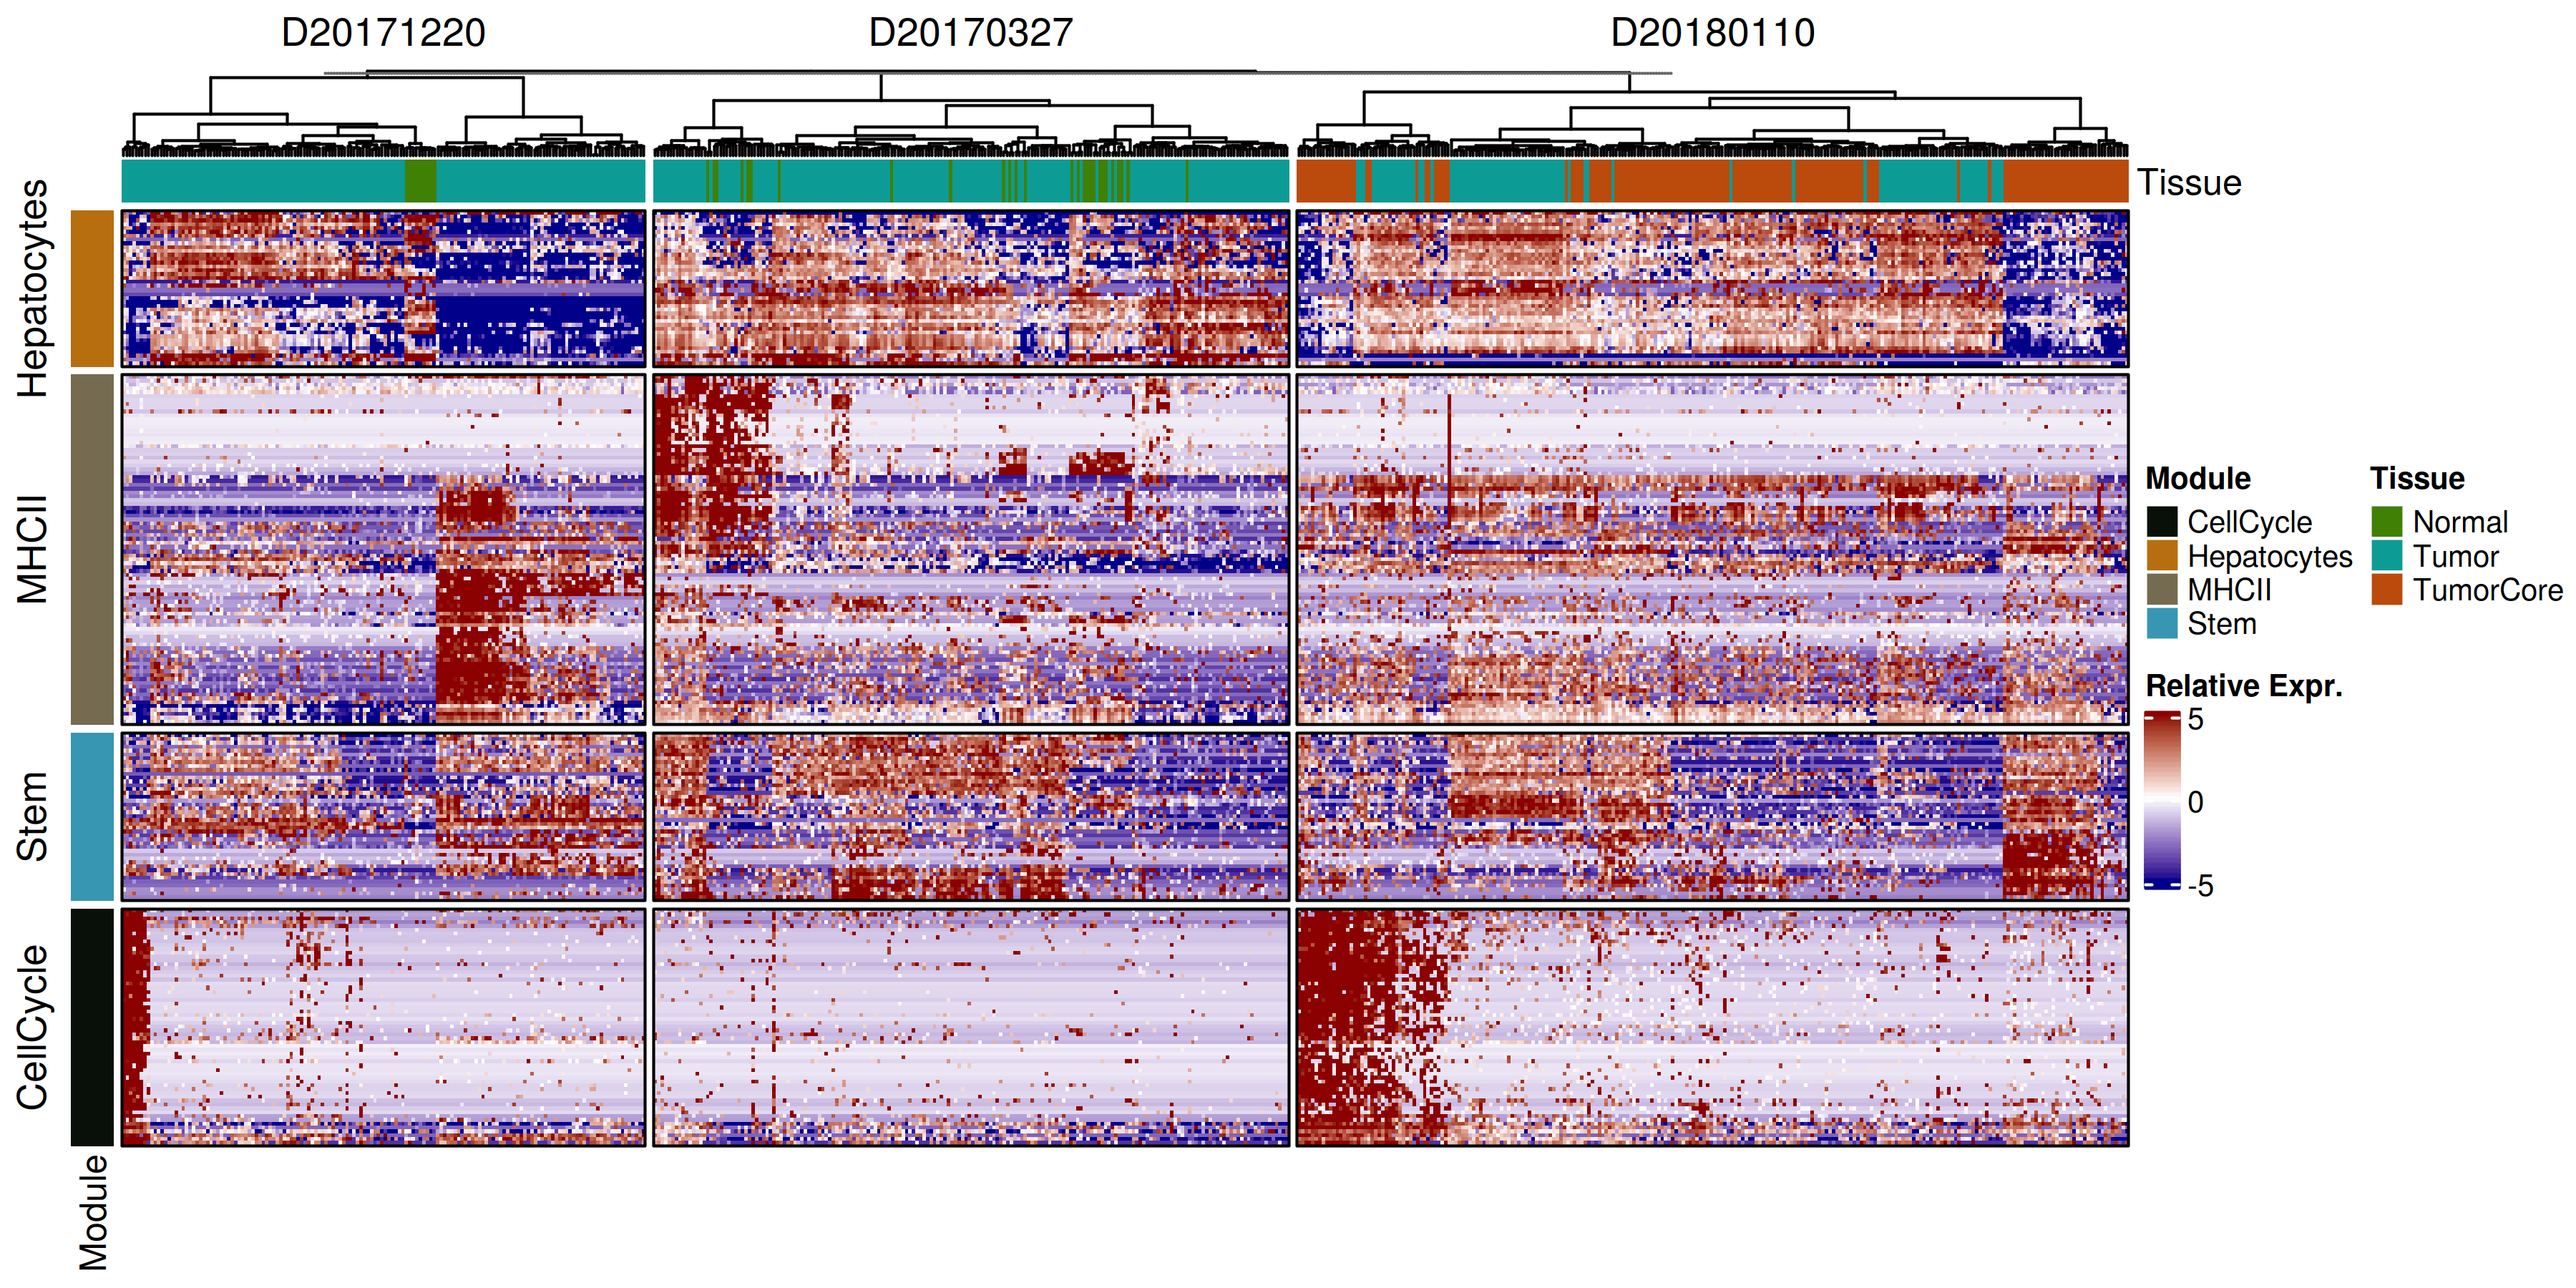

In [248]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 300)
col_fun <- circlize::colorRamp2(c(-5, 0, 5), c("darkblue", "white", "darkred"))
Heatmap(mt, name = 'Relative Expr.', col = col_fun, cluster_rows = T,  row_split = module_df$Module,use_raster = T,
        top_annotation = ha, left_annotation =  rowAnnotation( Module = module_df$Module),
        show_row_names = F, column_split = sub$donor, show_row_dend = F, 
        clustering_method_columns = "ward.D2", clustering_method_rows = 'ward.D2', show_column_names = F, border = T) 

Picking joint bandwidth of 0.394



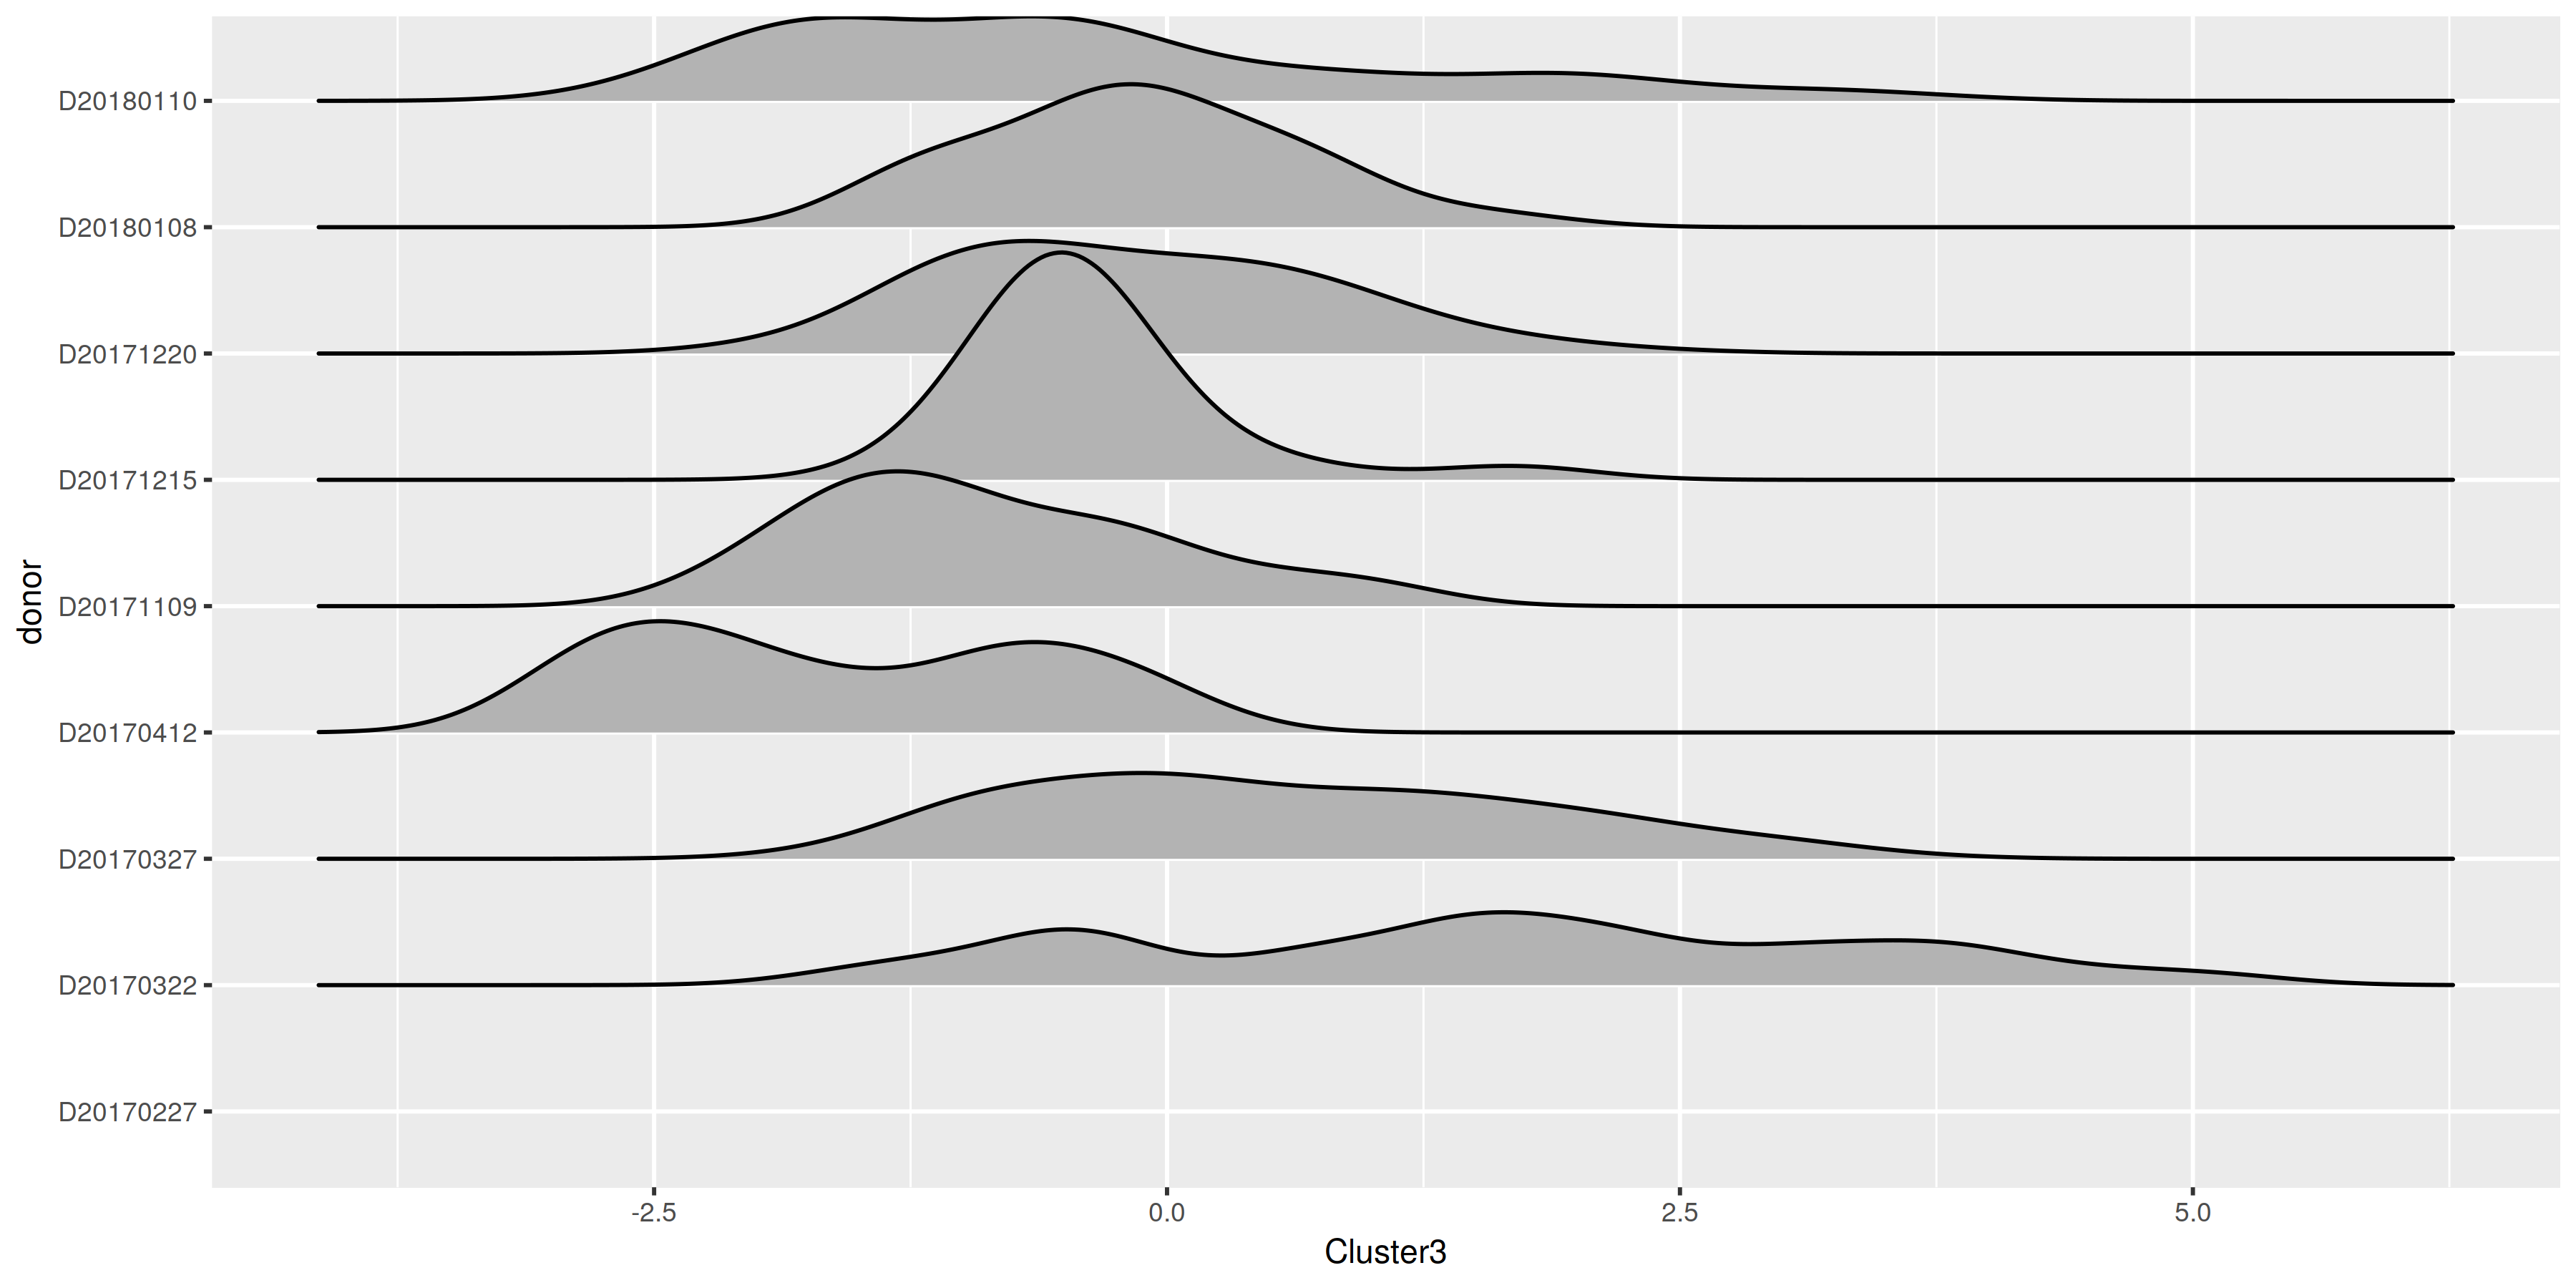

In [247]:
ggplot(plotDF, aes( y = donor,  x= Cluster3))+
 ggridges::geom_density_ridges()

In [66]:
p1 <- plotUMAP(sce, colour_by = "Cluster1") + scale_color_distiller(palette = "RdBu", direction = -1)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



In [158]:
p2 <- plotUMAP(sce, colour_by = "Cluster3") + scale_color_distiller(palette = "RdBu", direction = -1)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



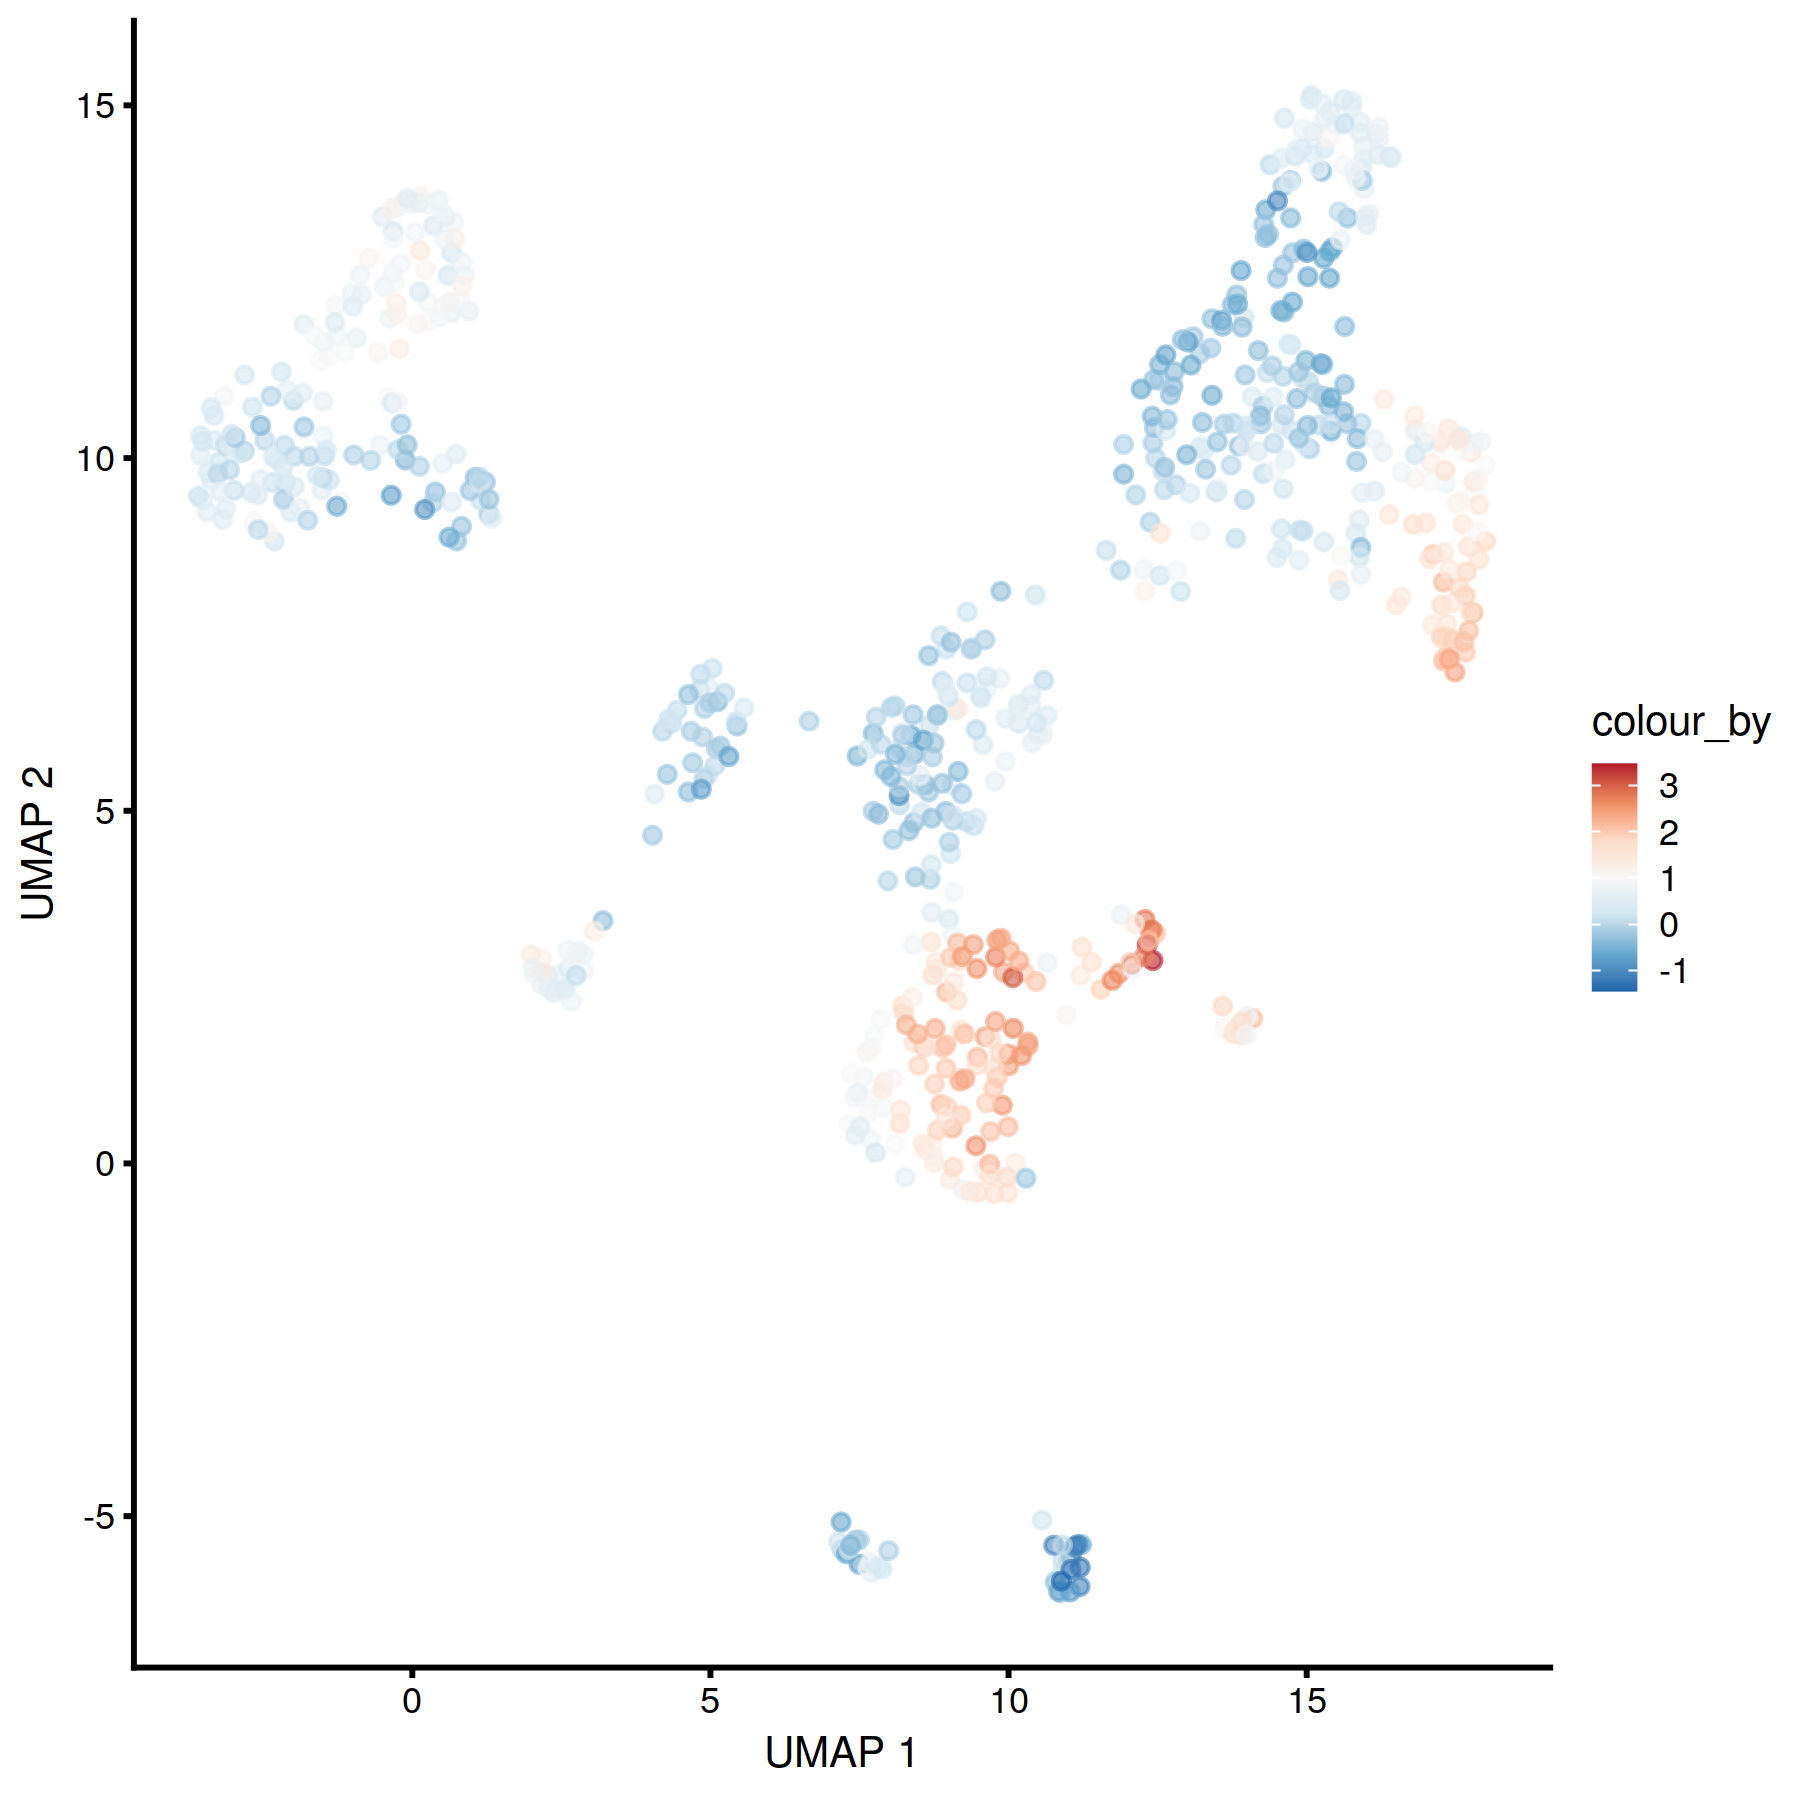

In [159]:
p2

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



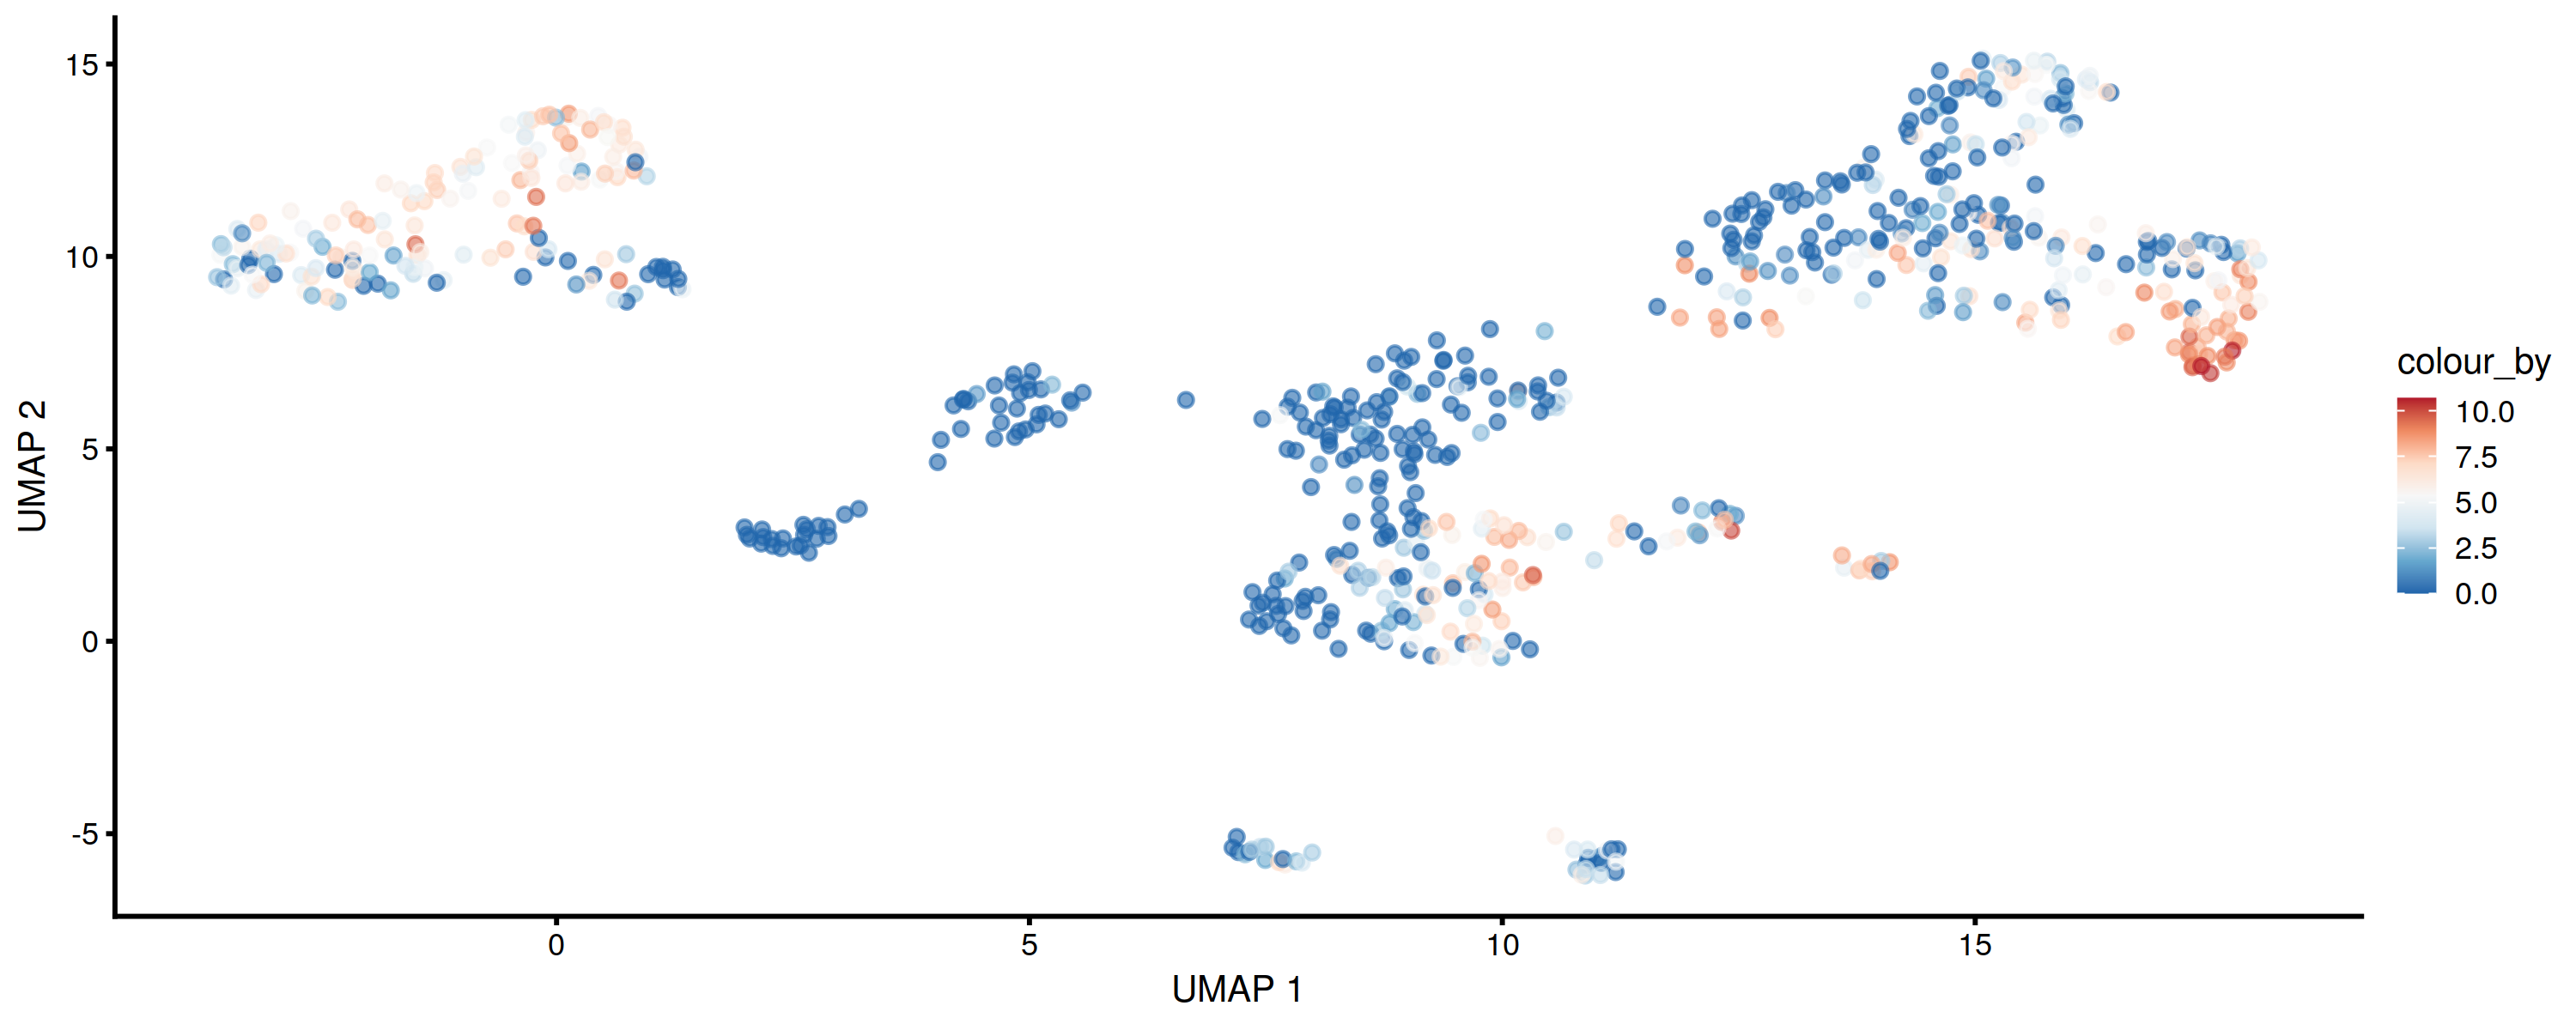

In [104]:
 plotUMAP(sce, colour_by = "SOX4") + scale_color_distiller(palette = "RdBu", direction = -1)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



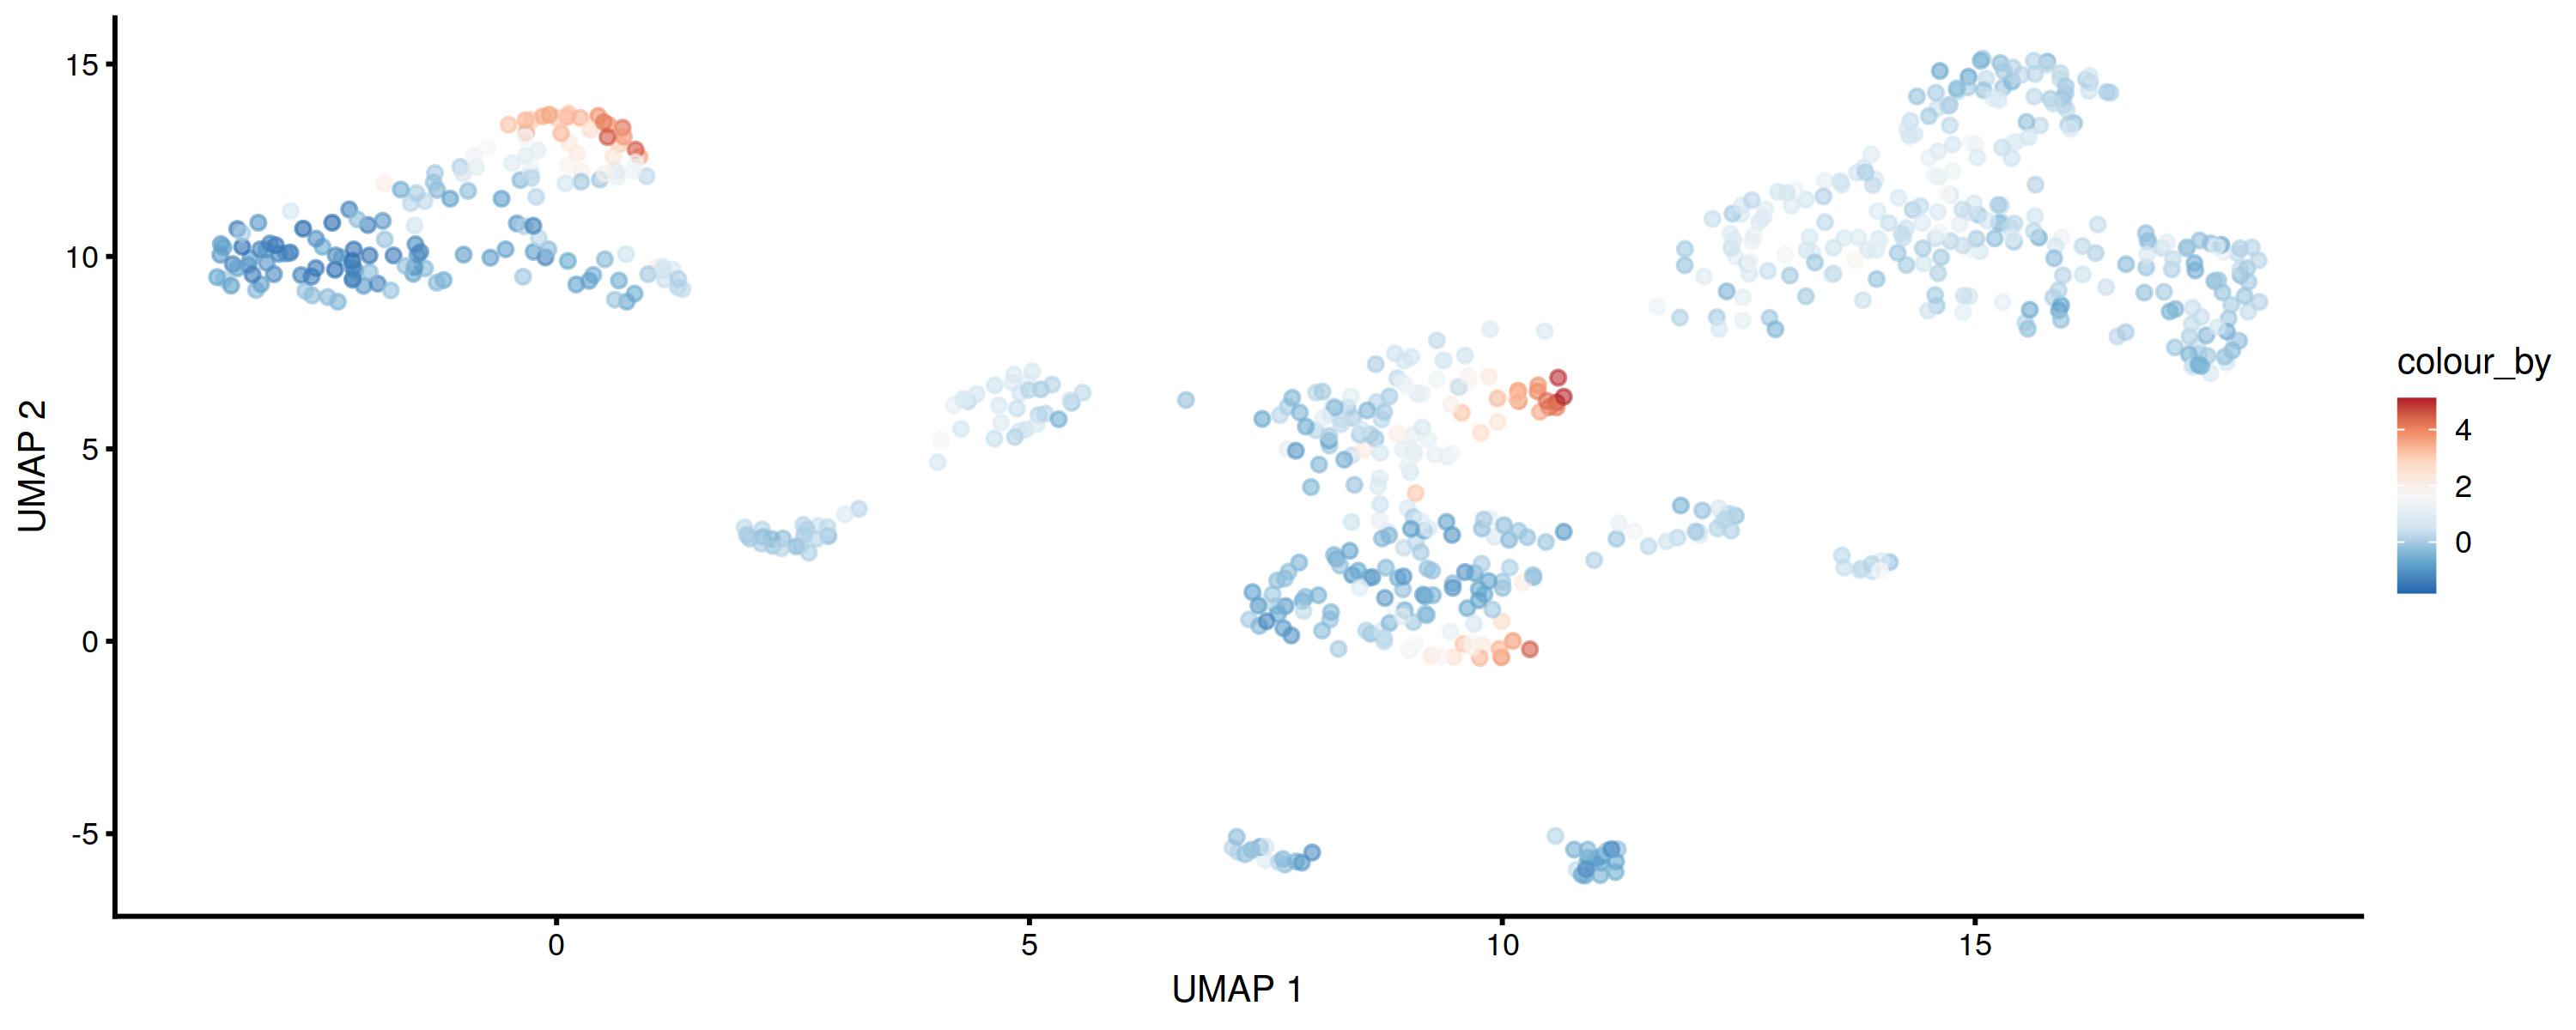

In [99]:
 plotUMAP(sce, colour_by = "Cluster2") + scale_color_distiller(palette = "RdBu", direction = -1)

In [79]:
p3 <- plotUMAP(sce, colour_by = "CD24") + scale_color_distiller(palette = "RdBu", direction = -1)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



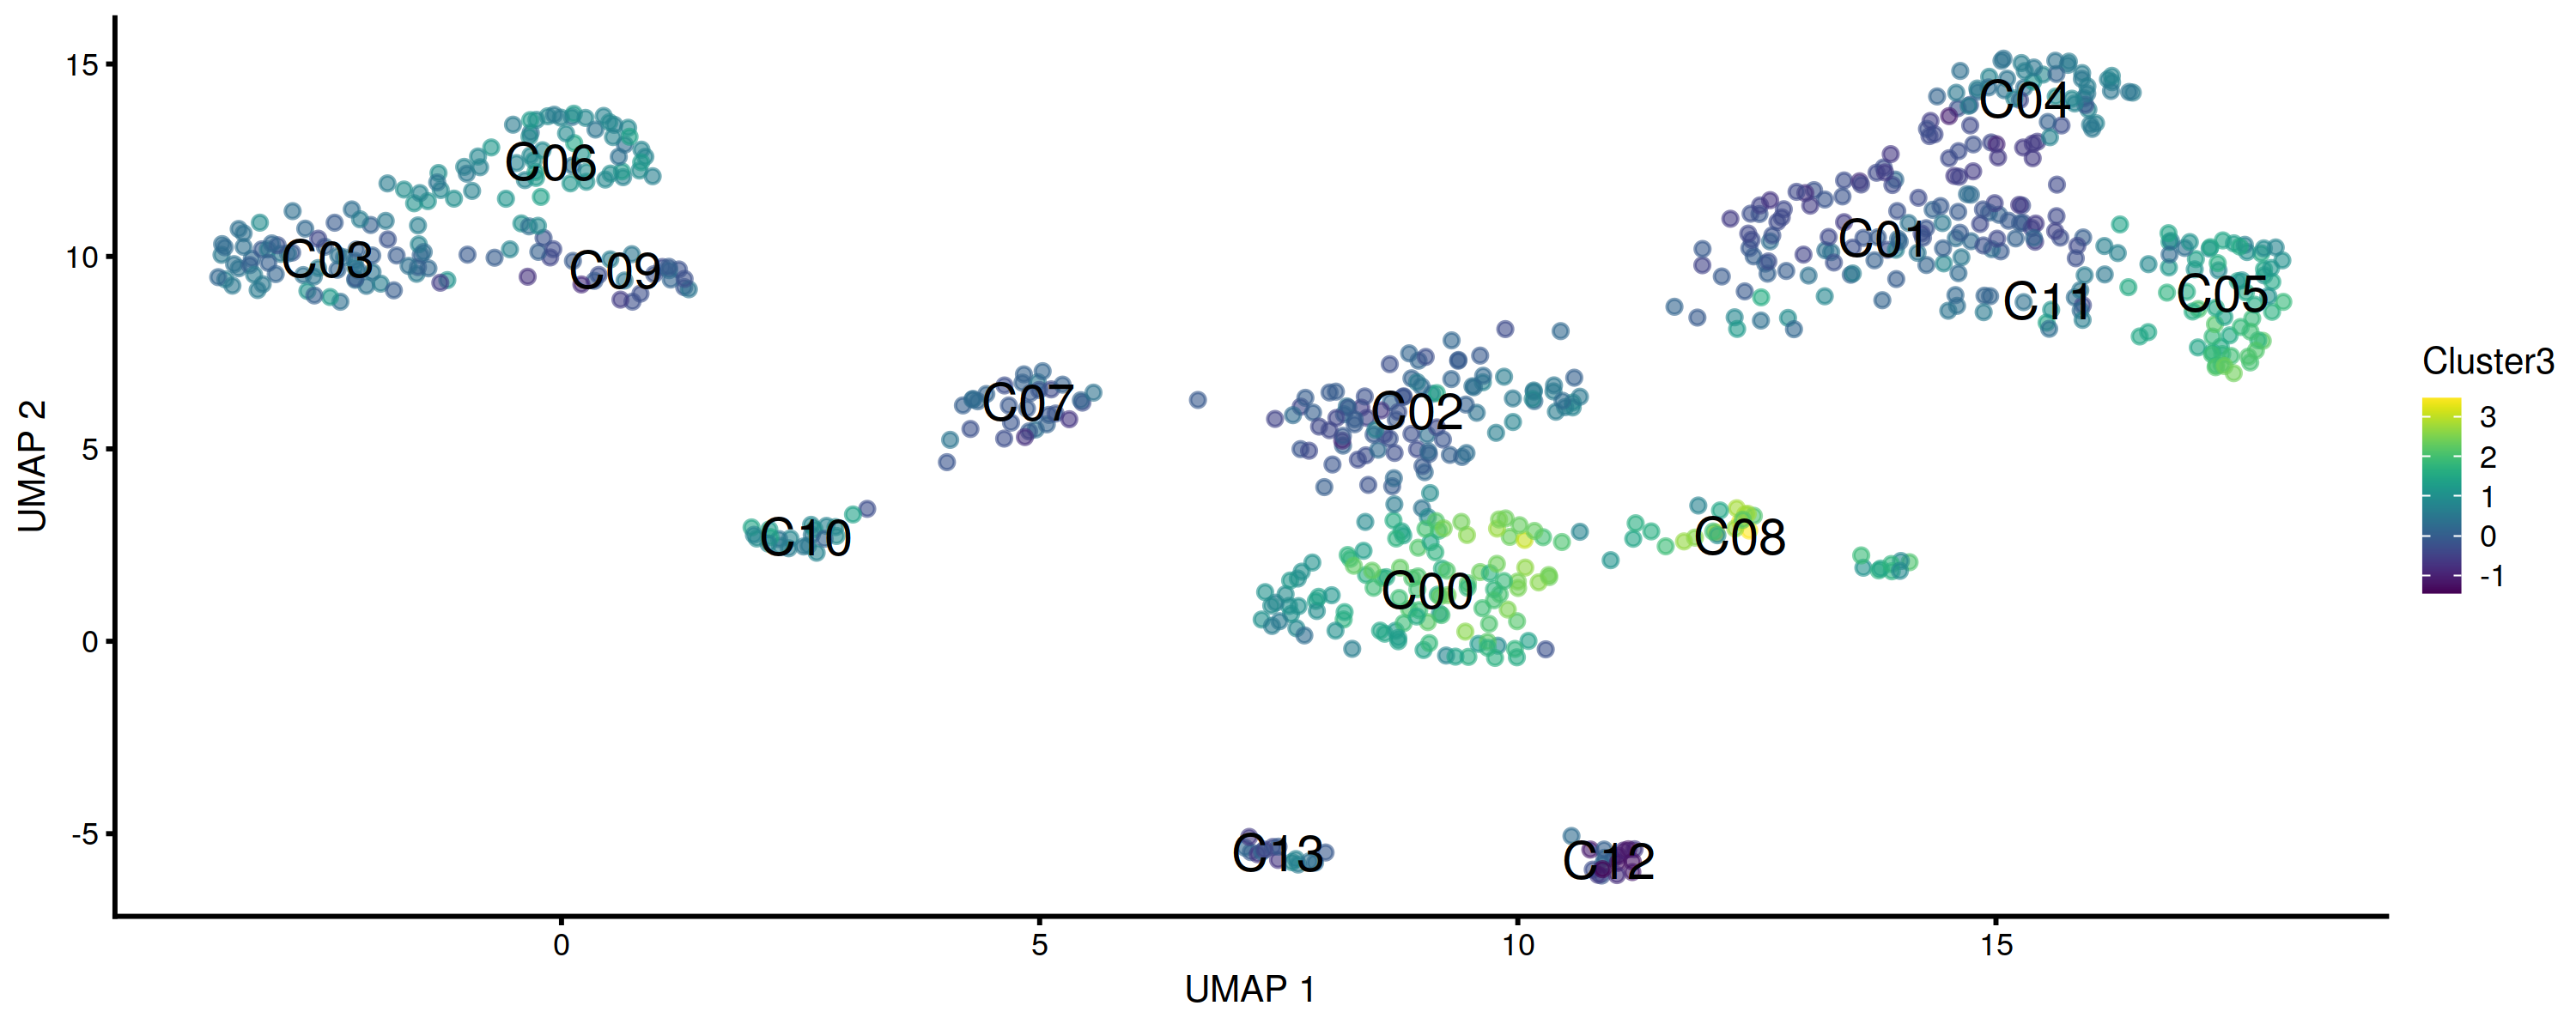

In [97]:
plotUMAP(sce, colour_by = "Cluster3", text_by = "leiden_sub")

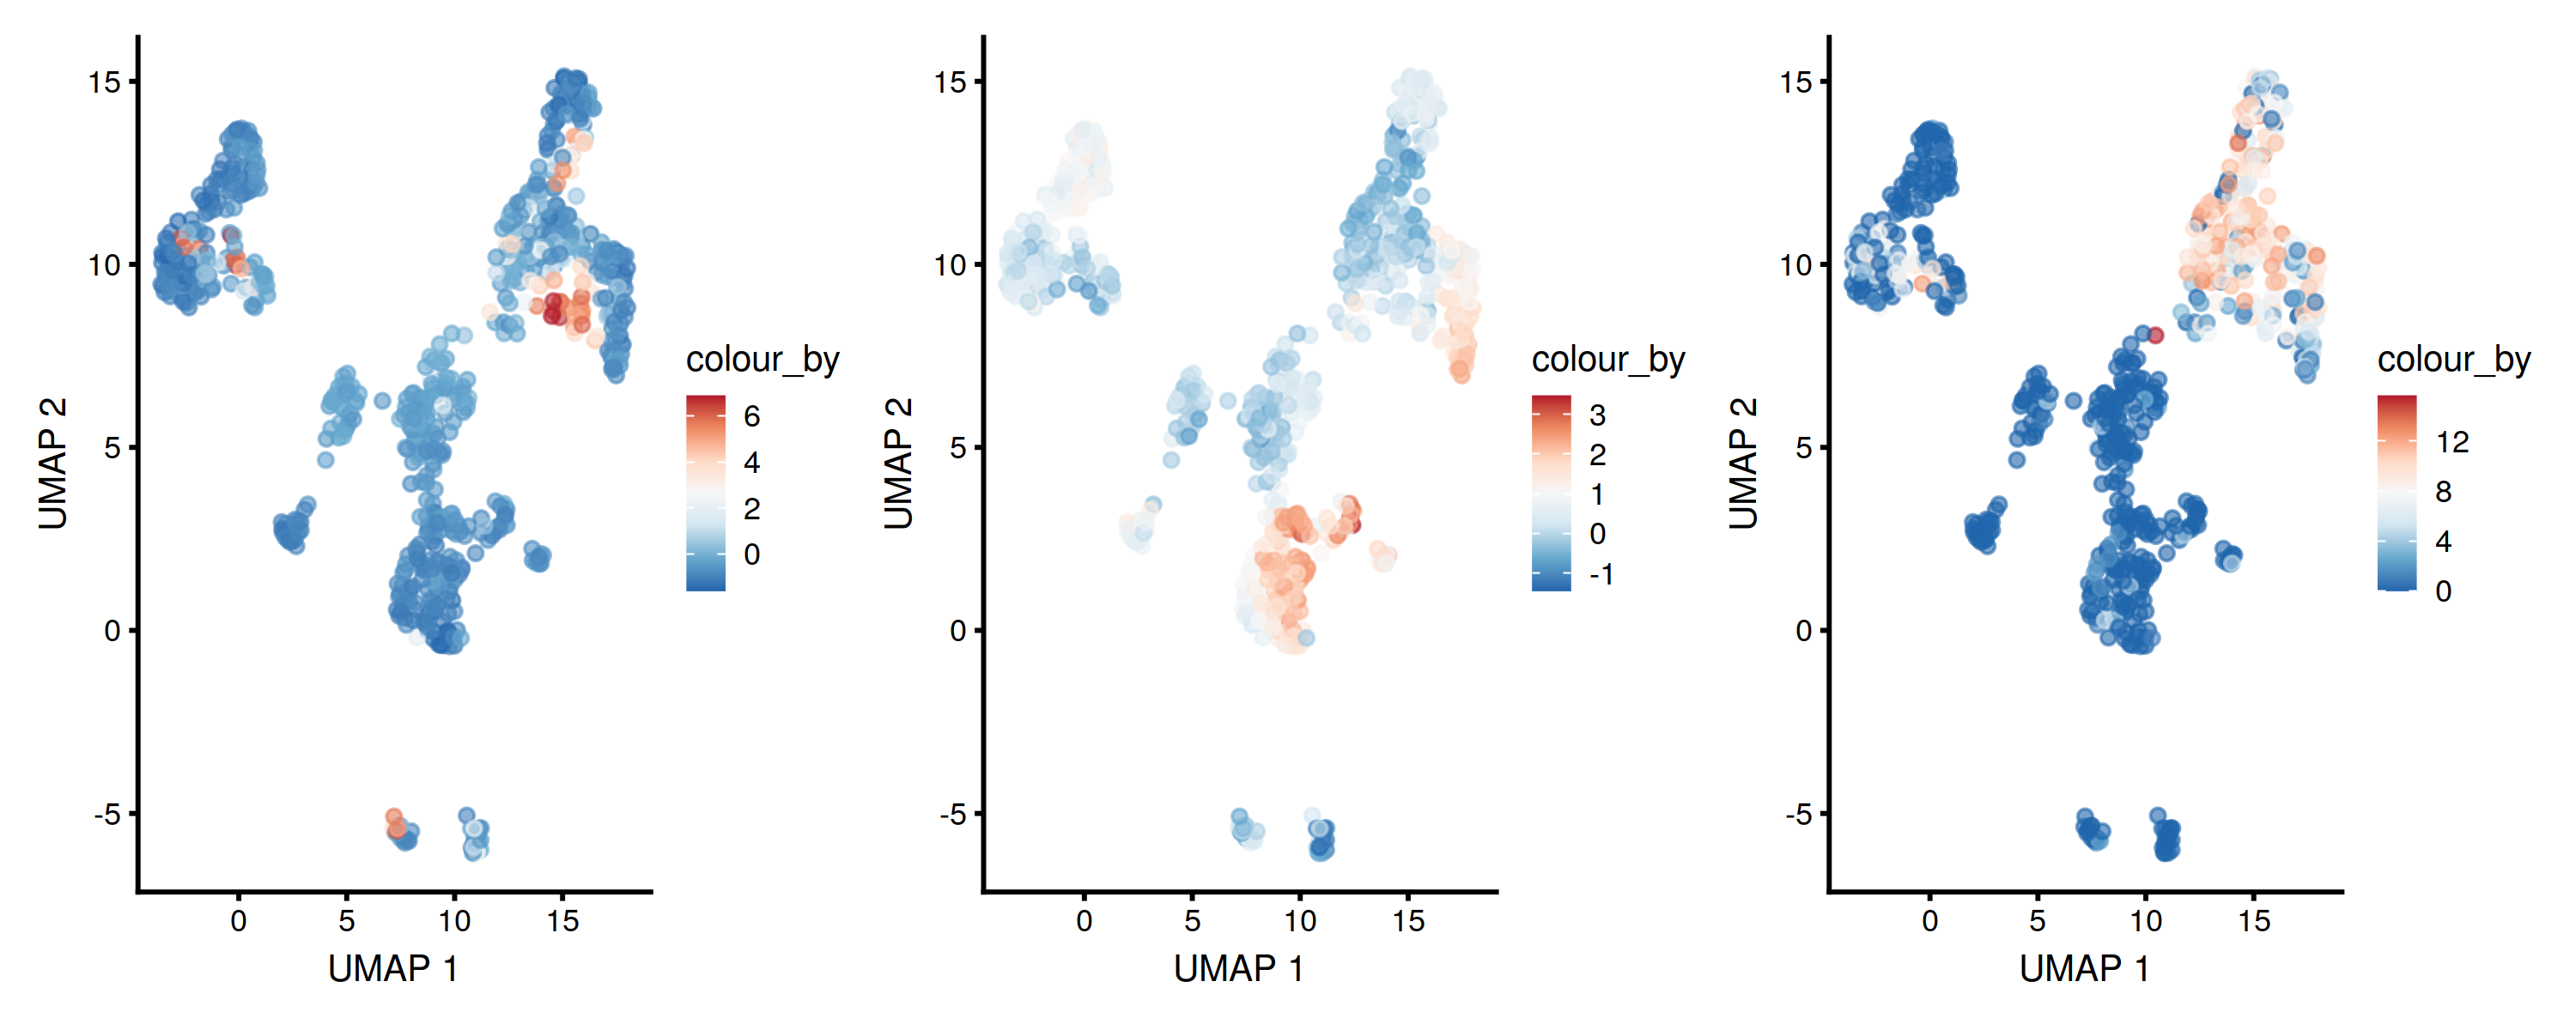

In [78]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)

p1 + p2 + p3

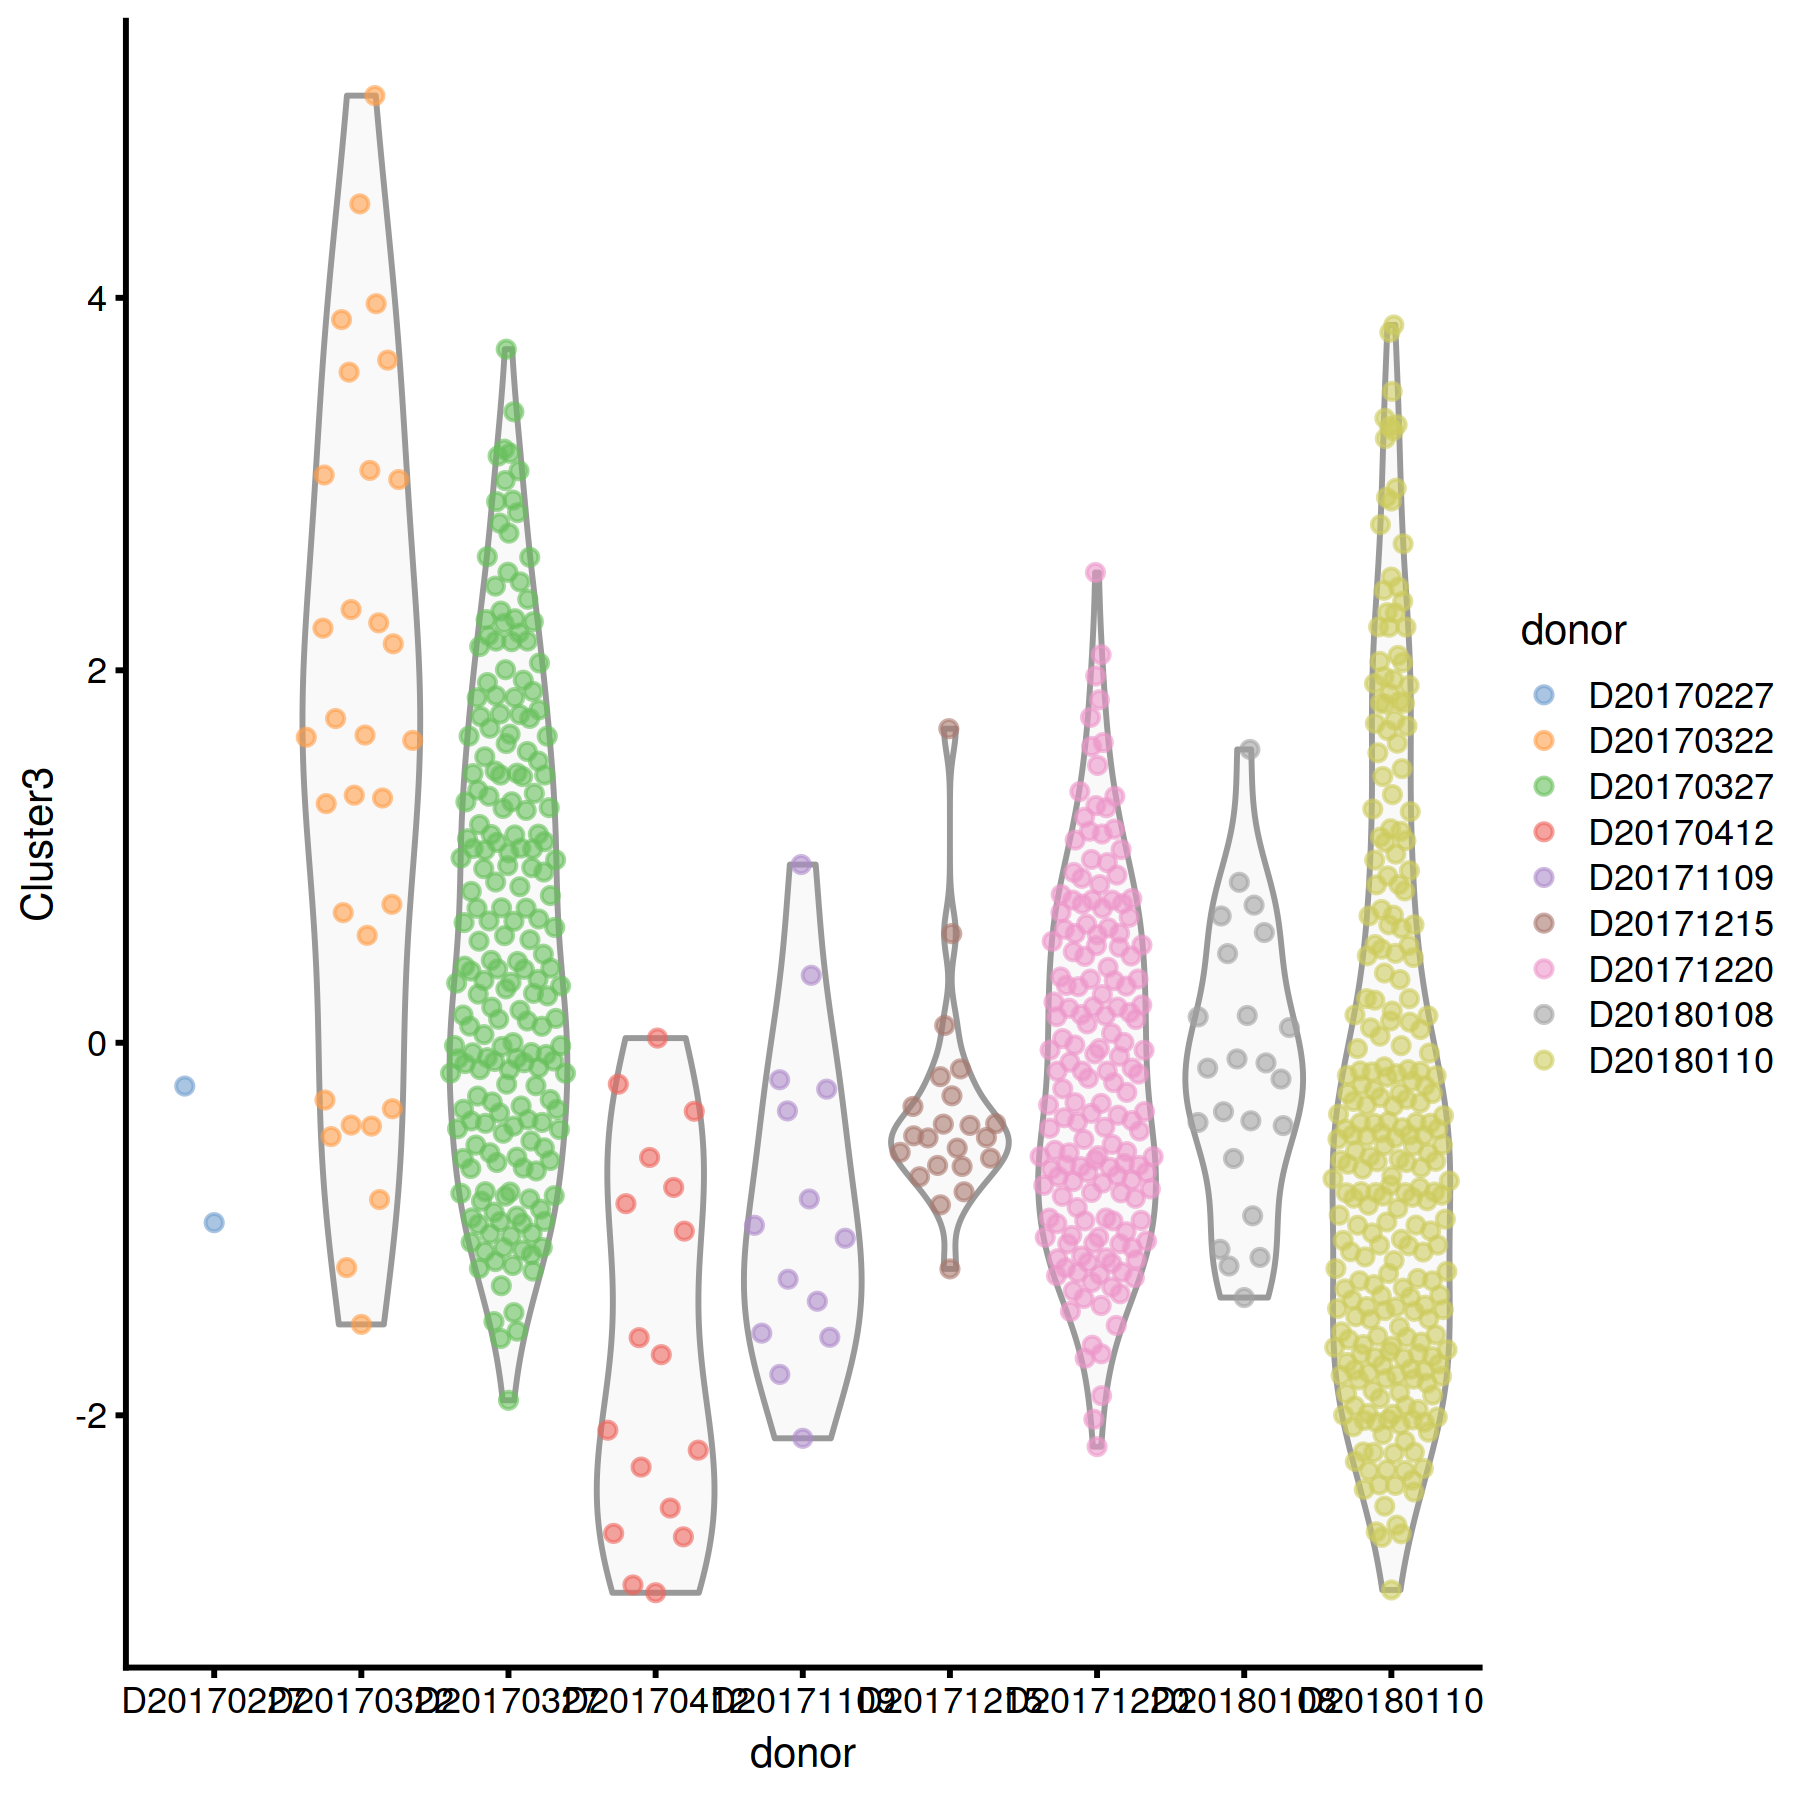

In [181]:
plotColData(sce, x =  "donor", y = "Cluster3", colour_by = "donor")

In [ ]:
plotDF$

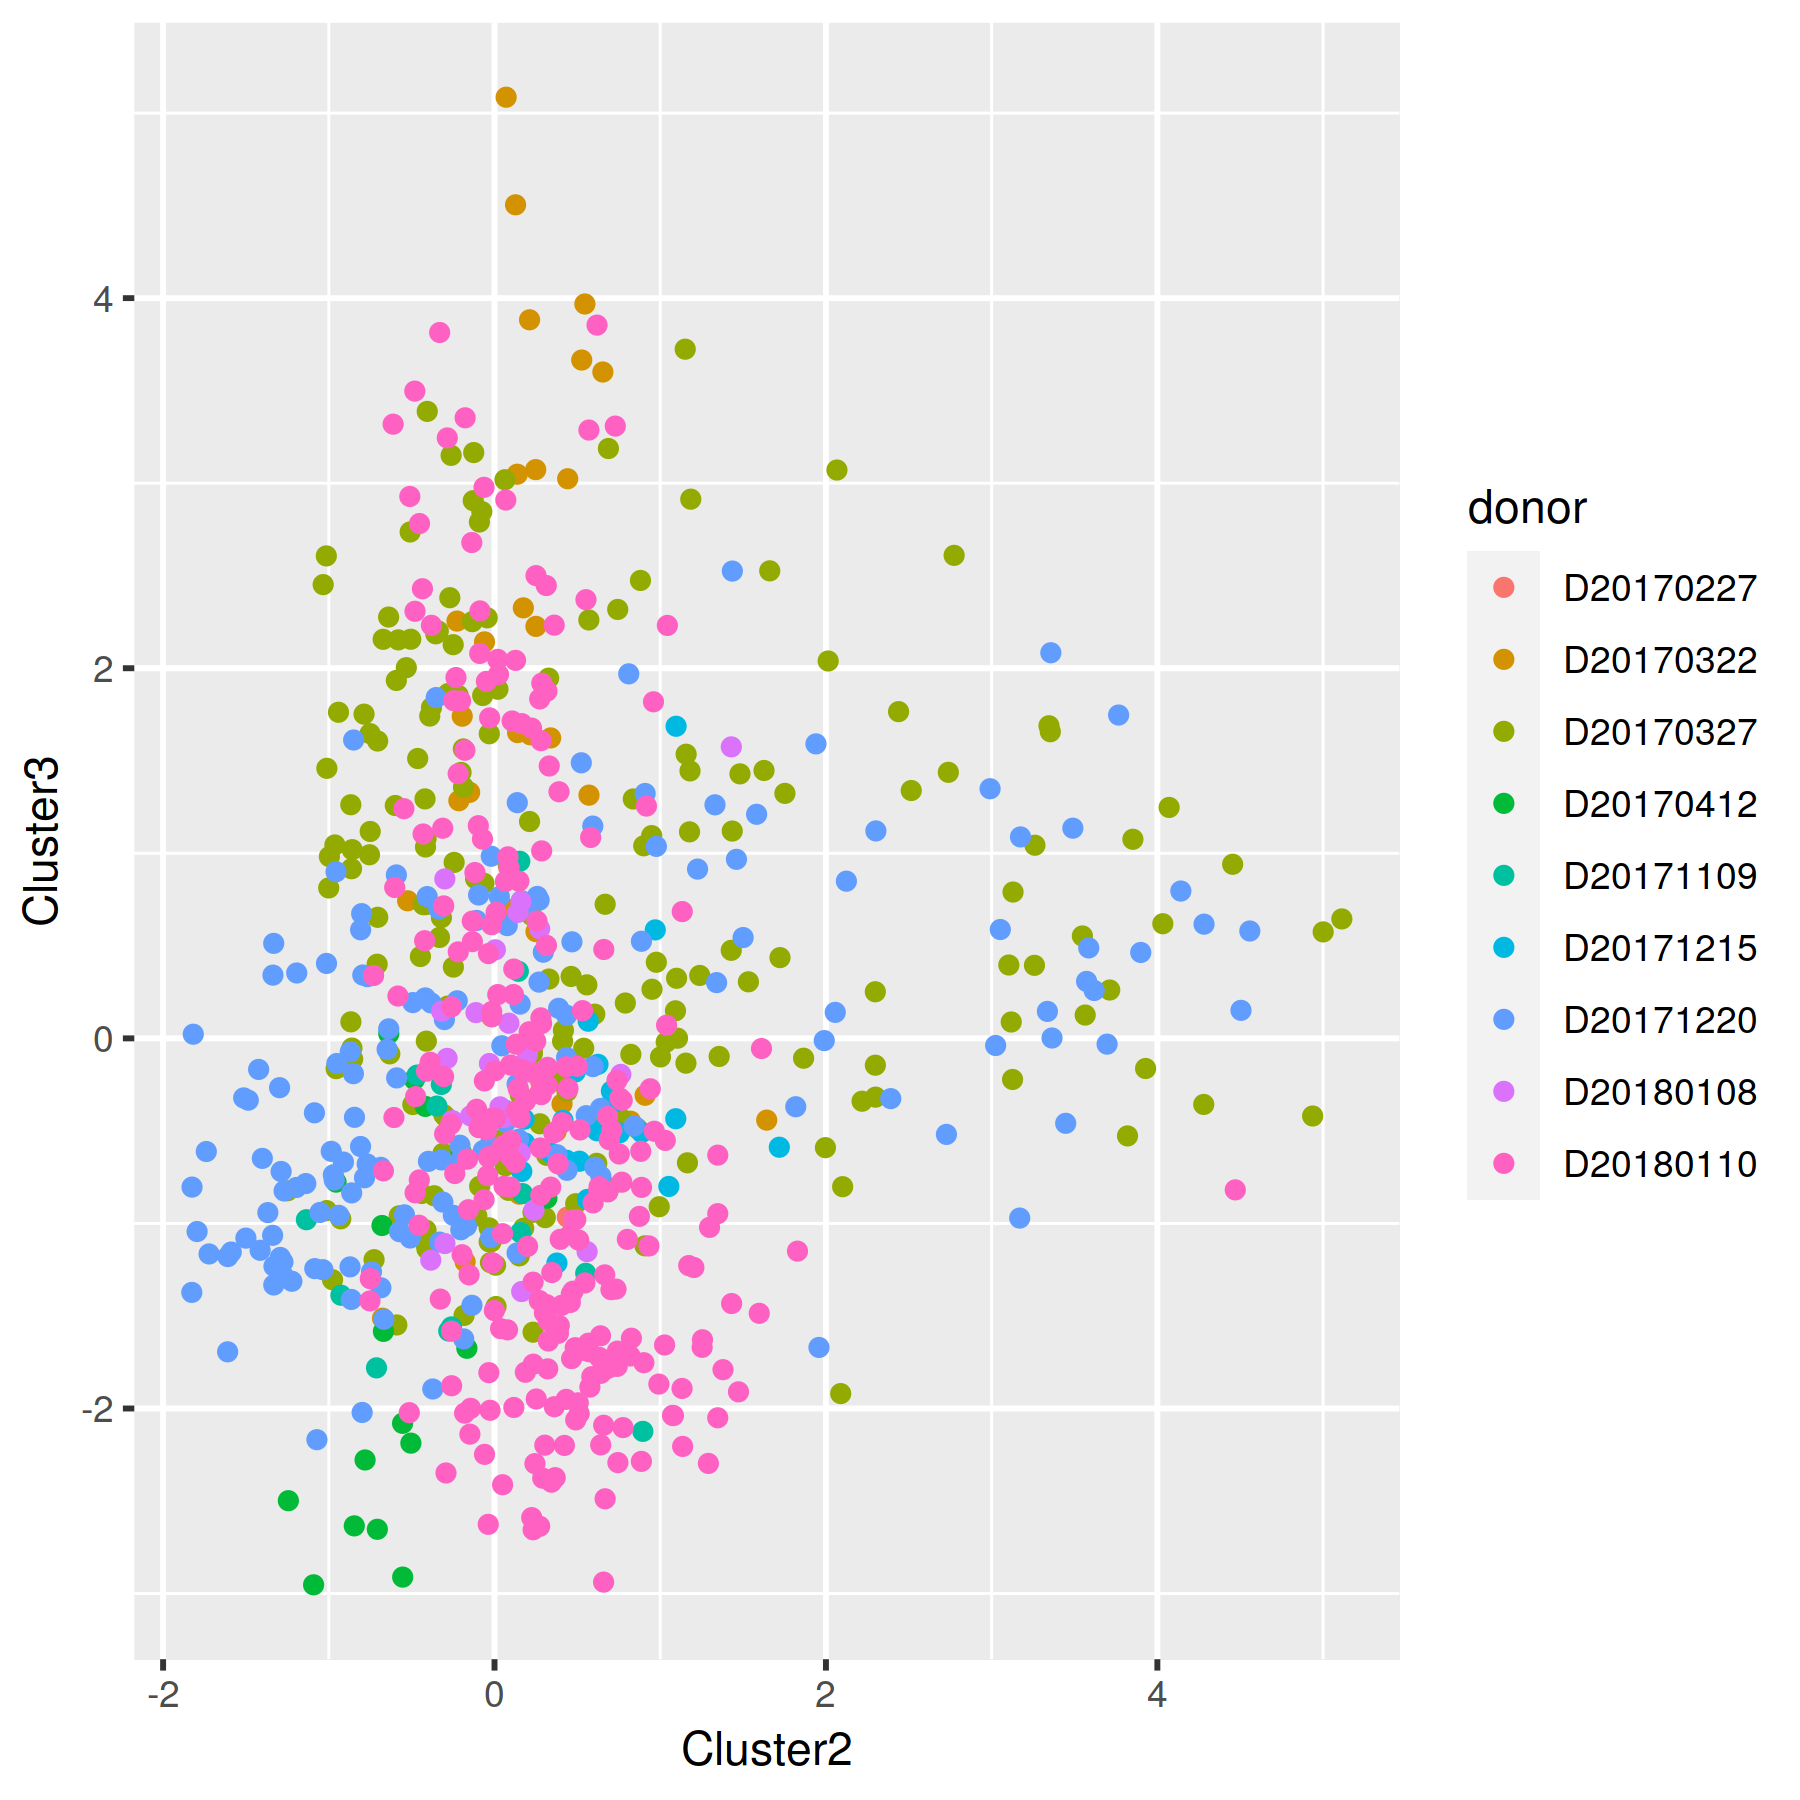

In [182]:
ggplot(plotDF, aes(x = Cluster2, y = Cluster3)) +
    geom_point(aes(fill = donor, color = donor), shape = 21) 

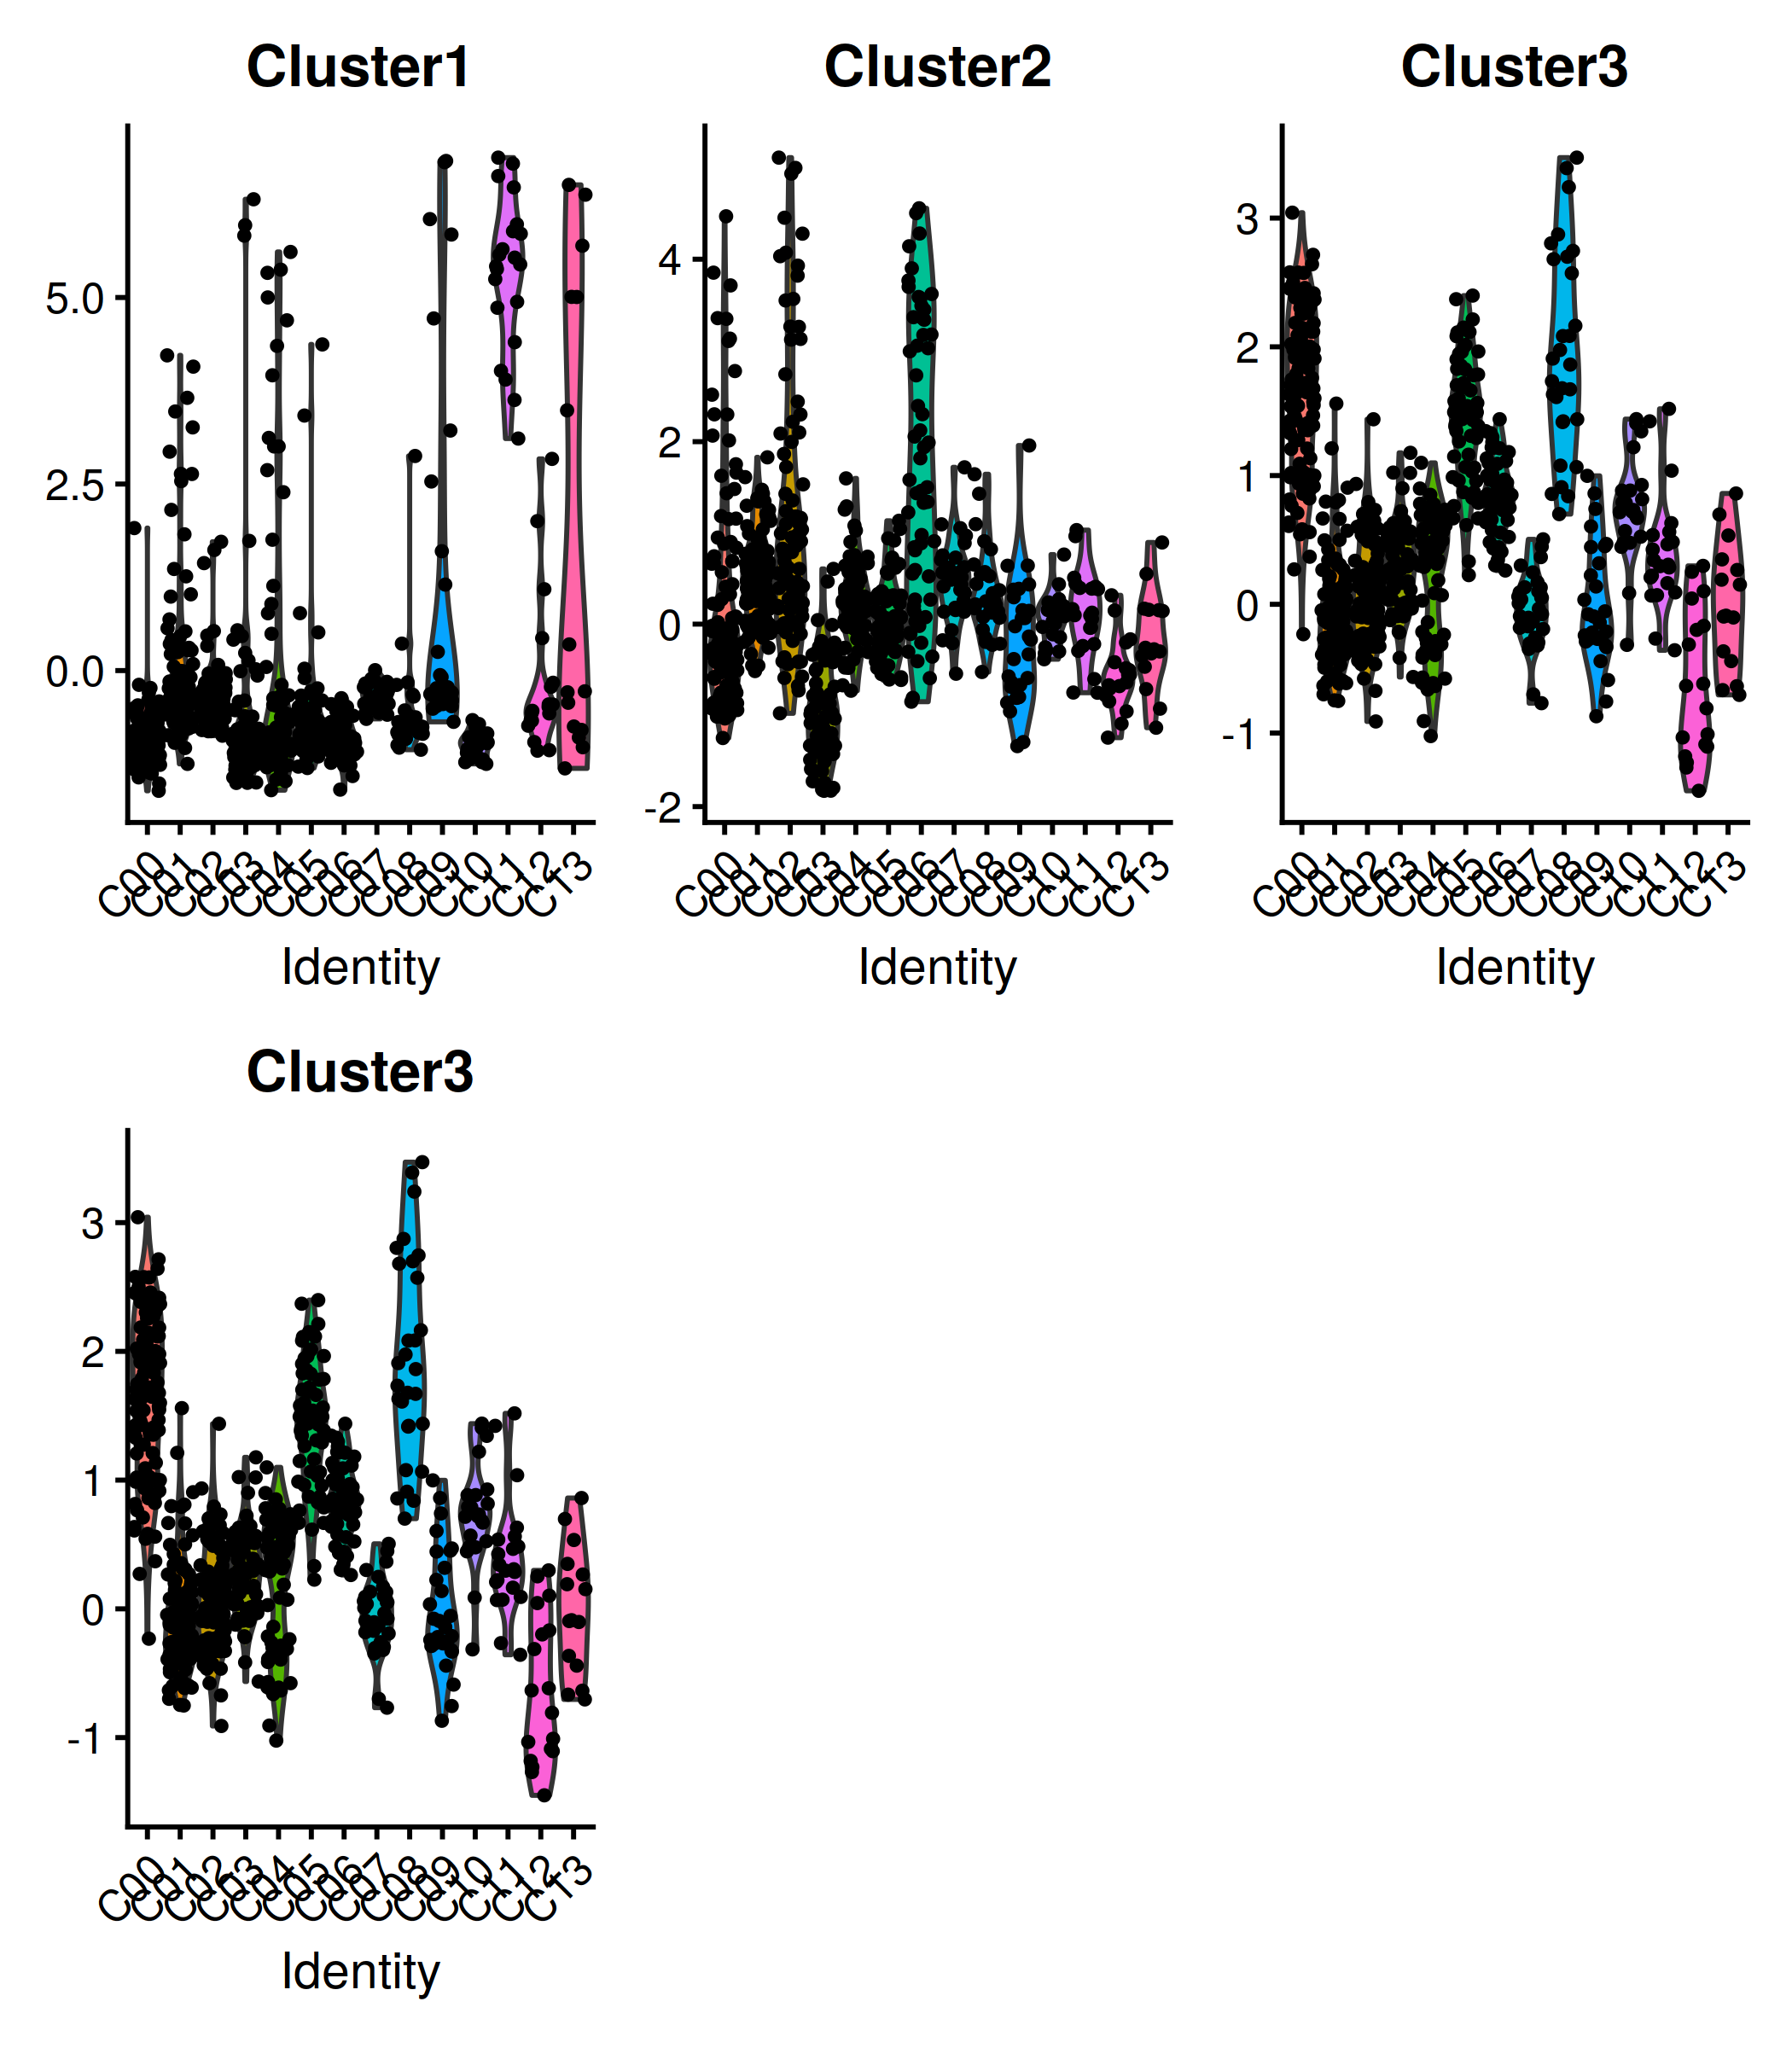

In [52]:
options(repr.plot.8width = 16, repr.plot.height = 8, repr.plot.res = 300)

Seurat::VlnPlot(sr, features = c("Cluster1", "Cluster2", "Cluster3", "Cluster3"), group.by = "leiden_sub")

In [37]:
table(nmf_programs_genes$CellCycle > 0.5)


FALSE  TRUE 
   22    39 